In [1]:
import gzip
import os
import io
import xarray as xr
import os
import numpy as np
import metpy
import metpy.calc as mpcalc
from metpy.units import units
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import glob
import pandas as pd
from PIL import Image
from olr_to_tb import *
import math
import wrf
from netCDF4 import Dataset
import fsspec
import zarr
from wrf import getvar
import gc


src_dir = r"C:\Users\miles\Downloads\mcs_data\unzipped"

In [2]:
ds = xr.open_mfdataset(
    os.path.join(src_dir, "*.nc"),
    engine="netcdf4",
    chunks={"Time": 1}, 
    concat_dim="Time",
    combine="nested"
)

In [3]:
# calculate avo (need to get from each file individually to use getvar)
file_paths = sorted(glob.glob(os.path.join(src_dir, "*.nc")))
avo_list = []
cape_list = []
ctt_list = []
dbz_list = []
helicity_list = []
pvo_list = []
td2_list = []
updraft_helicity_list = []
uvmet10_list = []
uv_met_list = []
temp_list = []
slp_list = []
p_list = []
z_list = []
w_list = []
i = 0

for fpath in file_paths:
    i+=1
    print(i)
    with Dataset(fpath) as ncfile:
        avo = getvar(ncfile, "avo")
        cape = getvar(ncfile, "cape_2d")
        ctt = getvar(ncfile, "ctt")
        dbz = getvar(ncfile, "dbz")
        helicity = getvar(ncfile, "helicity")
        pvo = getvar(ncfile, "pvo")
        td2 = getvar(ncfile, "td2")
        updraft_helicity = getvar(ncfile, "updraft_helicity")
        uvmet10 = getvar(ncfile, "uvmet10")
        uvmet = getvar(ncfile, "uvmet")
        temp = getvar(ncfile, "temp")
        slp = getvar(ncfile, "slp")
        p = getvar(ncfile, "pressure")
        z = getvar(ncfile, "z")
        w = getvar(ncfile, "wa")

        avo_list.append(avo.expand_dims("Time"))
        cape_list.append(cape.expand_dims("Time"))
        ctt_list.append(ctt.expand_dims("Time"))
        dbz_list.append(dbz.expand_dims("Time"))
        helicity_list.append(helicity.expand_dims("Time"))
        pvo_list.append(pvo.expand_dims("Time"))
        td2_list.append(td2.expand_dims("Time"))
        updraft_helicity_list.append(updraft_helicity.expand_dims("Time"))
        uvmet10_list.append(uvmet10.expand_dims("Time"))
        uv_met_list.append(uvmet.expand_dims("Time"))
        temp_list.append(temp.expand_dims("Time"))
        slp_list.append(slp.expand_dims("Time"))
        p_list.append(p.expand_dims("Time"))
        z_list.append(z.expand_dims("Time"))
        w_list.append(w.expand_dims("Time"))
        

# Concatenate into a single DataArray
avo_all = xr.concat(avo_list, dim="Time")
cape_all = xr.concat(cape_list, dim="Time")
ctt_all = xr.concat(ctt_list, dim="Time")
dbz_all = xr.concat(dbz_list, dim="Time")
helicity_all = xr.concat(helicity_list, dim="Time")
pvo_all = xr.concat(pvo_list, dim="Time")
td2_all = xr.concat(td2_list, dim="Time")
updraft_helicity_all = xr.concat(updraft_helicity_list, dim="Time")
uvmet10_all = xr.concat(uvmet10_list, dim="Time")
uv_met_all = xr.concat(uv_met_list, dim="Time")
temp_all = xr.concat(temp_list, dim ="Time")
slp_all = xr.concat(slp_list, dim="Time")
p_all = xr.concat(p_list, dim="Time")
z_all = xr.concat(z_list, dim="Time")
w_all = xr.concat(w_list, dim="Time")

ds["avo"] = avo_all
ds["cape"] = cape_all.sel(mcape_mcin_lcl_lfc = 'mcape')
ds["cin"] = cape_all.sel(mcape_mcin_lcl_lfc = 'mcin')
ds["lcl"] = cape_all.sel(mcape_mcin_lcl_lfc = 'lcl')
ds["lfc"] = cape_all.sel(mcape_mcin_lcl_lfc = 'lfc')
ds["ctt"] = ctt_all
ds["dbz"] = dbz_all
ds["helicity"] = helicity_all
ds["pvo"] = pvo_all
ds["td2"] = td2_all
ds["updraft_helicity"] = updraft_helicity_all
ds["u_met10"] = uvmet10_all.sel(u_v = 'u')
ds["v_met10"] = uvmet10_all.sel(u_v = 'v')
ds["u_met"] = uv_met_all.sel(u_v = 'u')
ds["v_met"] = uv_met_all.sel(u_v = 'v')
ds["temp"] = temp_all
ds["slp"] = slp_all
ds['avo_500'] = wrf.interplevel(avo_all, p_all, 500)
ds['pvo_500'] = wrf.interplevel(pvo_all, p_all, 500)
ds['avo_700'] = wrf.interplevel(avo_all, p_all, 700)
ds['pvo_700'] = wrf.interplevel(pvo_all, p_all, 700)

ds['u_300'] = wrf.interplevel(ds["u_met"], p_all, 300)
ds['v_300'] = wrf.interplevel(ds["v_met"], p_all, 300)
ds['z_300'] = wrf.interplevel(z_all, p_all, 300)

ds['u_500'] = wrf.interplevel(ds["u_met"], p_all, 500)
ds['v_500'] = wrf.interplevel(ds["v_met"], p_all, 500)
ds['z_500'] = wrf.interplevel(z_all, p_all, 500)

ds['u_700'] = wrf.interplevel(ds["u_met"], p_all, 700)
ds['v_700'] = wrf.interplevel(ds["v_met"], p_all, 700)
ds['z_700'] = wrf.interplevel(z_all, p_all, 700)

ds['u_850'] = wrf.interplevel(ds["u_met"], p_all, 850)
ds['v_850'] = wrf.interplevel(ds["v_met"], p_all, 850)
ds['z_850'] = wrf.interplevel(z_all, p_all, 850)


ds['w_300'] = wrf.interplevel(w_all, p_all, 300)
ds['w_500'] = wrf.interplevel(w_all, p_all, 500)
ds['w_700'] = wrf.interplevel(w_all, p_all, 700)
ds['w_850'] = wrf.interplevel(w_all, p_all, 850)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [4]:
# WIND SHEAR
g = 9.81  # Acceleration due to gravity (m/s^2)
z = (ds['PH'] + ds['PHB']) / g  # Geopotential height in meters
z = 0.5 * (z[:, :-1, :, :] + z[:, 1:, :, :])
z_target = 6000  # Target height in meters

bottom_top_levels = ds['bottom_top_stag']
z_diff = np.abs(z - z_target)
z_index = z_diff.argmin(dim='bottom_top_stag')  # Index of closest level to 6 km

def extract_level(var, level_idx):
    return var[level_idx]

# Apply to u and v wind
u_6km = xr.apply_ufunc(
    extract_level,
    ds['u_met'], z_index,
    input_core_dims=[['bottom_top'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[ds['u_met'].dtype]
)

v_6km = xr.apply_ufunc(
    extract_level,
    ds['v_met'], z_index,
    input_core_dims=[['bottom_top'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[ds['v_met'].dtype]
)

u_0km = ds['u_met10'] 
v_0km = ds['v_met10']

delta_u = u_6km.values - u_0km
delta_v = v_6km.values - v_0km

# Calculate wind shear magnitude
shear = np.sqrt(np.square(delta_u) + np.square(delta_v))

ds['U_shear_6'] = delta_u
ds['V_shear_6'] = delta_v
ds['mag_shear_6'] = shear

# CLOUD HEIGHT

temp_difs = np.abs(ds['temp'] - ds['ctt'] - 273.15)
temp_index = temp_difs.argmin(dim='bottom_top')
cloud_heights = z.isel(bottom_top_stag = temp_index.compute())
ds['CL_HT'] = cloud_heights

# RAIN
ds['RAIN'] = ds['RAINC'] + ds['RAINNC']
rains = np.zeros_like(ds['RAIN'])
tot_rain = ds['RAINC'] + ds['RAINNC']
rains[0, :, :] = np.zeros_like(ds['RAIN'].isel(Time = 0))
rains[12, :, :] = np.zeros_like(ds['RAIN'].isel(Time = 0))
for i in range(1, 12):
    rains[i, :, :] = tot_rain.isel(Time = i) - tot_rain.isel(Time = i - 1)
for i in range(13, 25):
    rains[i, :, :] = tot_rain.isel(Time = i) - tot_rain.isel(Time = i - 1)
ds['RAIN'] = (['Time', 'south_north', 'west_east'], rains)

# other variables
ds['U_1'] = ds['u_met'].isel(bottom_top = 10)
ds['V_1'] = ds['v_met'].isel(bottom_top = 10)
ds['WIND_sfc_mag'] = np.sqrt(np.square(ds['u_met10']) + np.square(ds['v_met10']))
ds['theta'] = ds['T'] + ds['T00']

c:\Users\miles\miniconda3\envs\mcs\lib\site-packages\dask\array\gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 20
  tmp = blockwise(
c:\Users\miles\miniconda3\envs\mcs\lib\site-packages\dask\array\gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 20
  tmp = blockwise(


In [5]:
hails = np.zeros_like(ds['HAILNC'])
tot_hail = ds['HAILNC']
hails[0, :, :] = np.zeros_like(ds['HAILNC'].isel(Time = 0))
hails[12, :, :] = np.zeros_like(ds['HAILNC'].isel(Time = 0))
for i in range(1, 12):
    hails[i, :, :] = tot_hail.isel(Time = i) - tot_hail.isel(Time = i - 1)
for i in range(13, 25):
    hails[i, :, :] = tot_hail.isel(Time = i) - tot_hail.isel(Time = i - 1)
ds['HAIL'] = (['Time', 'south_north', 'west_east'], hails)

In [6]:
import json

def sanitize_attrs(attrs):
    clean_attrs = {}
    for k, v in attrs.items():
        try:
            json.dumps(v)  # Test if it's serializable
            clean_attrs[k] = v
        except (TypeError, ValueError):
            print(f"Removing non-serializable attribute: {k} = {v}")
    return clean_attrs

# Clean dataset-level attrs
ds.attrs = sanitize_attrs(ds.attrs)

# Clean attrs for each variable
for var in ds.variables:
    ds[var].attrs = sanitize_attrs(ds[var].attrs)

Removing non-serializable attribute: WEST-EAST_GRID_DIMENSION = 925
Removing non-serializable attribute: SOUTH-NORTH_GRID_DIMENSION = 664
Removing non-serializable attribute: BOTTOM-TOP_GRID_DIMENSION = 38
Removing non-serializable attribute: DX = 1333.333251953125
Removing non-serializable attribute: DY = 1333.333251953125
Removing non-serializable attribute: AERCU_OPT = 0
Removing non-serializable attribute: AERCU_FCT = 1.0
Removing non-serializable attribute: IDEAL_CASE = 0
Removing non-serializable attribute: DIFF_6TH_SLOPEOPT = 0
Removing non-serializable attribute: AUTO_LEVELS_OPT = 0
Removing non-serializable attribute: DIFF_6TH_THRESH = 0.10000000149011612
Removing non-serializable attribute: DZBOT = 50.0
Removing non-serializable attribute: DZSTRETCH_S = 1.2999999523162842
Removing non-serializable attribute: DZSTRETCH_U = 1.100000023841858
Removing non-serializable attribute: SKEBS_ON = 0
Removing non-serializable attribute: SPEC_BDY_FINAL_MU = 1
Removing non-serializable att

In [7]:
ds['REFL_10CM_sfc'] = ds['REFL_10CM'].isel(bottom_top = 0)
ds['theta_sfc'] = ds['theta'].isel(bottom_top = 0)
ds['avo_sfc'] = ds['avo'].isel(bottom_top = 0)
ds['pvo_sfc'] = ds['pvo'].isel(bottom_top = 0)

In [8]:
ds.to_zarr(src_dir + '/processed_data.zarr', mode = 'w')

In [2]:
# start here if file already exists
ds = xr.open_zarr(src_dir + '/processed_data.zarr', chunks='auto')

c:\Users\miles\miniconda3\envs\mcs\lib\site-packages\xarray\conventions.py:289: SerializationWarning: variable 'dbz' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
c:\Users\miles\miniconda3\envs\mcs\lib\site-packages\xarray\conventions.py:289: SerializationWarning: variable 'pvo' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
c:\Users\miles\miniconda3\envs\mcs\lib\site-packages\xarray\conventions.py:289: SerializationWarning: variable 'pvo_sfc' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
c:\Users\miles\miniconda3\envs\mcs\lib\site-packages\xarray\conventions.py:289: SerializationWarning: variable 'td2' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
c:\Users\miles\miniconda3\envs\mcs\lib\site-packages\xarray\conventions.

In [3]:
# in mrms: mask number 4 (both res). In WRF: mask number 6 for 4/3km and 7 for 4km.
mask_dir = r"C:\Users\miles\Downloads\mcs_masks"
filepaths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".nc")])

# Open and concatenate along the time dimension
masks = xr.open_mfdataset(
    filepaths,
    concat_dim="time",
    combine="nested"
)

In [63]:
def make_maps(ds, var, title, x_barb=None, y_barb=None, scale=1, shift=0, barbscale=1,
              cmap='viridis', bottom=None, top=None, bottom_top=0, show=False, save=False,
              save_loc=None, thin=30, zoom=None, feature_ds=None, feature_id=None):
    
    var_data = ds[var]
    if x_barb:
        u_data = ds[x_barb]
        v_data = ds[y_barb]

        if 'bottom_top' in u_data.dims:
            u_data = u_data.sel(bottom_top=bottom_top)
        if 'bottom_top' in v_data.dims:
            v_data = v_data.sel(bottom_top=bottom_top)

        thin_slice = slice(None, None, thin)
        u_data = u_data.isel(south_north=thin_slice, west_east=thin_slice)
        v_data = v_data.isel(south_north=thin_slice, west_east=thin_slice)
        
    else:
        u_data = None
        v_data = None

    if zoom is not None and zoom != 'auto' and len(zoom) == 4:
        var_data = var_data.where(
            ((var_data.XLAT >= zoom[2]) & (var_data.XLAT <= zoom[3]) &
            (var_data.XLONG >= zoom[0]) & (var_data.XLONG <= zoom[1])).compute(),
            drop=True
        )

    if scale == None:
        scale = 1
    if shift == None:
        shift = 0
    if barbscale == None:
        barbscale = 1
    if cmap == 'grey_to_white':
        cmap = plt.cm.gray  # Base colormap
        gray_to_white = cmap(np.linspace(0.5, 1, 256))  # Use the upper half of the colormap
        cmap = plt.matplotlib.colors.ListedColormap(gray_to_white)

    if 'bottom_top' in var_data.dims:
        global_min = var_data.isel(bottom_top=bottom_top).min().values*scale + shift
        global_max = var_data.isel(bottom_top=bottom_top).max().values*scale + shift
        var_data = var_data.isel(bottom_top=bottom_top)
    else:
        global_min = var_data.min().values*scale + shift
        global_max = var_data.max().values*scale + shift
    if bottom:
        global_min = bottom
    if top:
        global_max = top

    range_mag = 10 ** math.floor(math.log10(global_max - global_min))

    # Round down min_val and up max_val to the nearest multiple of range_mag
    global_min = math.floor(global_min / range_mag) * range_mag
    global_max = math.ceil(global_max / range_mag) * range_mag

    if bottom == 2000: # manual override for cloud heights
        global_min = 2000
    if var == 'updraft_helicity':
        global_min = 0
    if var == 'helicity':
        global_min = -500
        global_max = 500
    if var == 'ctt':
        global_min = -80
        global_max = 20
    if var == 'updraft_helicity':
        global_min = -200
        global_max = 200
    if var in ['avo', 'avo_500', 'avo_700']:
        global_min = -100
        global_max = 100
    if var == 'slp':
        global_min = 1005
        global_max = 1015
    if var in ['pvo', 'pvo_500', 'pvo_700']:
        global_min = -40
        global_max = 40

    # Get coordinate names once, not every frame
    lat_coord = [name for name in var_data.coords if "LAT" in name][0]
    long_coord = [name for name in var_data.coords if "LONG" in name][0]
    if x_barb:
        ulat_coord = [name for name in u_data.coords if "LAT" in name][0]
        ulong_coord = [name for name in u_data.coords if "LONG" in name][0]

    projection = ccrs.LambertConformal()
    coast = cfeature.COASTLINE.with_scale('50m')
    states = cfeature.STATES.with_scale('50m')
    borders = cfeature.BORDERS.with_scale('50m')


    def process_timestep(i, var_data, lat_coord, long_coord, title,
                     bottom_top, x_barb, u_data, v_data, zoom, cmap,
                     scale, shift, barbscale, global_min, global_max,
                     feature_ds, feature_id, save, save_loc, show, projection, coast, states, borders):
    
        time = var_data['XTIME'].isel(Time=i)
        frame = var_data.isel(Time=i)
        frame = (frame.load() * scale + shift)

        if x_barb:
        
            frameu = u_data.isel(Time=i)
            frameu = (frameu.load() * barbscale)

            framev = v_data.isel(Time=i)
            framev = (framev.load() * barbscale)      

        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(111, projection=projection)

        lw = 3
        if zoom is None:
            lon_min = frame[long_coord].min().item()
            lon_max = frame[long_coord].max().item()
            lat_min = frame[lat_coord].min().item()
            lat_max = frame[lat_coord].max().item()
            ax.set_extent([lon_min, lon_max, lat_min, lat_max])
            lw = 1
        elif zoom == 'auto' and feature_ds is not None and feature_id is not None:
            # 1. grab the nearest feature frame
            feature_time = feature_ds.sel(
                time=pd.to_datetime(str(time.values)),
                method='nearest'
            )
            # 2. build a boolean mask of your track
            mask = (feature_time['tracknumber'].squeeze() == feature_id)
            # 3. if there’s nothing at this time, skip
            if not mask.any():
                return
            # 4. extract lon/lat of the masked cells
            lon = feature_time['lon'].where(mask)
            lat = feature_time['lat'].where(mask)
            lon_min = float(lon.min().values)
            lon_max = float(lon.max().values)
            lat_min = float(lat.min().values)
            lat_max = float(lat.max().values)

            
            ax.set_extent([
                lon_min, lon_max,
                lat_min, lat_max
            ], crs=ccrs.PlateCarree())

        elif len(zoom) == 8:
            if i < 6:
                return
            x0_i = zoom[0] + i * zoom[4]
            y0_i = zoom[1] + i * zoom[5]
            x1_i = zoom[0] + zoom[2] + i * zoom[6]
            y1_i = zoom[1] + zoom[3] + i * zoom[7]
            ax.set_extent([x0_i, x1_i, y0_i, y1_i])
        else:
            ax.set_extent(zoom)

        ax.add_feature(coast, linewidth=1)
        ax.add_feature(states, linewidth=0.5, edgecolor='black')
        ax.add_feature(borders, linewidth=1, edgecolor='black')
        

        plt1 = ax.pcolormesh(
            frame[long_coord], frame[lat_coord], frame, cmap=cmap,
            transform=ccrs.PlateCarree(), vmin=global_min, vmax=global_max)
        if x_barb:
            ax.barbs(
                frameu[ulong_coord].values, frameu[ulat_coord].values, frameu.values, framev.values, transform=ccrs.PlateCarree(), length = 6)
        
        # Overlay feature outline if provided
        if feature_ds is not None and feature_id is not None:
            # Match time index
            feature_time = feature_ds.sel(time=pd.to_datetime(str(time.values)), method='nearest')
            
            # Build mask for where tracknumber == feature_id
            mask = (feature_time['tracknumber'] == feature_id)
            mask_np = mask.squeeze().values
            mask_data = np.where(mask_np, 1.0, 0.0)
            
            # Plot contour
            ax.contour(
                feature_time['lon'], feature_time['lat'], mask_data,
                levels=[0.5], colors='black', linewidths=lw, transform=ccrs.PlateCarree(), zorder=9)
            ax.contour(
                feature_time['lon'], feature_time['lat'], mask_data,
                levels=[0.5], colors='white', linewidths=lw, linestyles = 'dashed', transform=ccrs.PlateCarree(), zorder=10)
        
        cbar = fig.colorbar(plt1, ax=ax, orientation='horizontal', pad=0.05, aspect=30)
        ax.set_title(
            'WRF ' + title,
            fontweight='bold', fontsize=14, loc='left')
        #dt = datetime.utcfromtimestamp(time.values.astype(int) * 1e-9)
        ax.set_title(time.values, fontsize=14, loc='right')
        # # Format the gridlines (optional)
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=True, dms=True, x_inline=False,
            y_inline=False, linewidth=1, color='k', linestyle=':')
        
        
        # Dynamically determine gridline spacing based on extent
        lon_min, lon_max, lat_min, lat_max = ax.get_extent(crs=ccrs.PlateCarree())

        def compute_spacing(min_val, max_val, desired_lines=6):
            span = max_val - min_val
            raw_spacing = span / desired_lines
            # Round to a "nice" number (1, 2, 5, 10, 20, etc.)
            exponent = math.floor(math.log10(raw_spacing))
            fraction = raw_spacing / (10 ** exponent)
            if fraction < 1.5:
                nice_spacing = 1
            elif fraction < 3:
                nice_spacing = 2
            elif fraction < 7:
                nice_spacing = 5
            else:
                nice_spacing = 10
            return nice_spacing * (10 ** exponent)

        lon_spacing = compute_spacing(lon_min, lon_max)
        lat_spacing = compute_spacing(lat_min, lat_max)

        gl.xlocator = mticker.MultipleLocator(lon_spacing)
        gl.ylocator = mticker.MultipleLocator(lat_spacing)

        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 16, 'rotation': 20}
        gl.ylabel_style = {'size': 16}
        #print(pd.to_datetime(str(time.values)).strftime('%d%H'))
        if save:
            if not os.path.exists(save_loc):
                os.makedirs(save_loc)
                
            plt.savefig(save_loc + pd.to_datetime(str(time.values)).strftime('%d%H') + '.png')
            # print('saved in ' + save_loc + pd.to_datetime(str(time.values)).strftime('%d%H') + '.png')
        if show:
            plt.show()
        
        plt.cla()
        plt.clf()
        plt.close('all')
        del mask, mask_np, mask_data, feature_time
        del fig, ax, cbar, gl
        del frame, plt1
        if x_barb:
            del frameu, framev
        gc.collect()
        
    for i in range(len(var_data['XTIME'])):
        process_timestep(i, var_data, lat_coord, long_coord, title,
                        bottom_top, x_barb, u_data, v_data, zoom, cmap,
                        scale, shift, barbscale, global_min, global_max,
                        feature_ds, feature_id, save, save_loc, show, projection, coast, states, borders)


#make_maps(combined_dataset, 'RAIN', 'Test', bottom = .1, top = 10, show = True)

In [64]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save(f"{frame_folder}/loop.gif", format="GIF", append_images=frames,
               save_all=True, duration=300, loop=0)

In [65]:
vars_of_interest = ['REFL_10CM_sfc', 'OLR', 'T2', 'mag_shear_6', 'CL_HT', 'ctt', 'cape', 'RAIN', 'WIND_sfc_mag', 'theta_sfc', 'helicity', 'pvo_sfc', 'avo_sfc', 'cin', 'updraft_helicity', 'slp', 'lcl', 'avo_500', 'pvo_500', 'avo_700', 'pvo_700', 'z_300', 'z_500', 'z_700', 'z_850', 'td2', 'w_300', 'w_500', 'w_700', 'w_850'] 
titles = ['Reflectivity (DBZ)', 'Outgoing Longwave Radiation (W/m2)', 
          '2m Temperature (F) and Wind Barbs', '0-6 km Wind Shear (Magnitude in kt and Barbs)', 'Cloud Top Height (m; Derived from Brightness Temp)', 
          'Cloud Top Temperature (degC)', 'CAPE (J/kg) and 0-6 km Wind Shear Barbs', 'Hourly Rain (mm)', 'Surface Wind (kt)', 'Surface Potential Temperature (K) and Wind Barbs',
          '0-3 km Storm Relative Helicity (m2/s2)', 'Potential Vorticity (PVU)', 'Absolute Vorticity (10-5 s-1)', 'CIN (J/kg)', 'Updraft Helicity (m2/s2)', 'Sea Level Pressure (hPa) and Surface Wind Barbs', 'Lifting Condensation Level (m)', '500 mb Absolute Vorticity (10-5 s-1)', '500 mb Potential Vorticity (PVU)', '700 mb Absolute Vorticity (10-5 s-1)', '700 mb Potential Vorticity (PVU)',
          '300 mb Height (dam) and Wind (kt)', '500 mb Height (dam) and Wind (kt)', '700 mb Height (dam) and Wind (kt)', '850 mb Height (dam) and Wind (kt)', '2m Dew Point (F) and Surface Wind Barbs',
          '300 mb Vertical Velocity (m/s)', '500 mb Vertical Velocity (m/s)', '700 mb Vertical Velocity (m/s)', '850 mb Vertical Velocity (m/s)']

x_barbs = [None, None, 'U10', 'U_shear_6', None, None, 'U_shear_6', None, 'U10', 'U10', None, None, None, None, None, 'U10', None, None, None, None, None, 'u_300', 'u_500', 'u_700', 'u_850', 'U10', None, None, None, None]
y_barbs = [None, None,  'V10', 'V_shear_6', None, None, 'V_shear_6', None, 'V10', 'V10', None, None, None, None, None, 'V10', None, None, None, None, None, 'v_300', 'v_500', 'v_700', 'v_850', 'V10', None, None, None, None]
save_folders = ['REFL_10CM',  'OLR', 'sfc_temp_wind', 'Shear', 'CL_HT', 'ctt', 'CAPE_shear', 'RAIN', 'WIND_sfc', 'sfc_theta_wind', 'helicity', 'pvo', 'avo', 'cin', 'updraft_helicity', 'slp', 'lcl', 'avo_500', 'pvo_500', 'avo_700', 'pvo_700', 'z_300', 'z_500', 'z_700', 'z_850', 'td2', 'w_300', 'w_500', 'w_700', 'w_850']
cmaps = ['turbo', 'binary', 'turbo', 'turbo', 'grey_to_white', 'binary', 'turbo', 'GnBu', 'turbo', 'turbo', 'seismic', 'turbo', 'seismic', 'PuBu', 'PuOr', 'RdBu_r', 'YlGn_r', 'seismic', 'turbo', 'seismic', 'turbo', 'RdBu_r', 'RdBu_r', 'RdBu_r', 'RdBu_r', 'YlGnBu', 'RdBu_r', 'RdBu_r', 'RdBu_r', 'RdBu_r'] 
bottoms = [1, None, None, None, None, -80, 1, .01, None, None, -500, -40, -100, 0, -200, 1005, 0, -100, -40, -100, -40, None, None, None, None, 45, -1, -1, -1, -1]
tops = [None, None, None, 60, None, 20, 1000, 10, None, None, 500, 40, 100, 400, 200, 1015, 2000, 100, 40, 100, 40, None, None, None, None, 60, 1, 1, 1, 1]
scales = [None, None, 9/5, 1.94384, None, None, None, None, 1.94384, None, None, None, None, None, None, None, None, None, None, None, None, .1, .1, .1, .1, 9/5, None, None, None, None]
shifts = [None, None, -459.67, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 32, None, None, None, None]
barbscales = [None, None, 1.94384, 1.94384, None, None, 1.94384, None, 1.94384, 1.94384, None, None, None, None, None, None, None, None, None, None, None, 1.94384, 1.94384, 1.94384, 1.94384, 1.94384, 1.94384, 1.94384, 1.94384, 1.94384]


indices = [14]
if indices is not None:
    vars_of_interest = [vars_of_interest[i] for i in indices]
    titles = [titles[i] for i in indices]
    x_barbs = [x_barbs[i] for i in indices]
    y_barbs = [y_barbs[i] for i in indices]
    save_folders = [save_folders[i] for i in indices]
    cmaps = [cmaps[i] for i in indices]
    bottoms = [bottoms[i] for i in indices]
    tops = [tops[i] for i in indices]
    scales = [scales[i] for i in indices]
    shifts = [shifts[i] for i in indices]
    barbscales = [barbscales[i] for i in indices]

i = 0
tot = len(vars_of_interest)
for var, title, x_barb, y_barb, scale, shift, barbscale, save_folder, cmap, bottom, top in zip(vars_of_interest, titles, x_barbs, y_barbs, scales, shifts, barbscales, save_folders, cmaps, bottoms, tops):
    i += 1
    print(save_folder, i, 'of', tot)
    make_maps(ds, var, title, x_barb, y_barb, scale = scale, shift = shift, barbscale = barbscale, bottom = bottom, top = top, cmap = cmap, save = True, save_loc = 'images/hires/' + save_folder + '/', feature_ds = masks, feature_id = 6)
    make_gif('images/hires/'+ save_folder)
    gc.collect()

updraft_helicity 1 of 1


In [66]:
# zoomed in plots
zoom = [-124, -119, 45, 49]
thin = 10

vars_of_interest = ['REFL_10CM_sfc', 'OLR', 'T2', 'mag_shear_6', 'CL_HT', 'ctt', 'cape', 'RAIN', 'WIND_sfc_mag', 'theta_sfc', 'helicity', 'pvo_sfc', 'avo_sfc', 'cin', 'updraft_helicity', 'slp', 'lcl', 'avo_500', 'pvo_500', 'avo_700', 'pvo_700', 'td2', 'w_300', 'w_500', 'w_700', 'w_850'] 
titles = ['Reflectivity (DBZ)', 'Outgoing Longwave Radiation (W/m2)', 
          '2m Temperature (F) and Wind Barbs', '0-6 km Wind Shear (Magnitude in kt and Barbs)', 'Cloud Top Height (m; Derived from Brightness Temp)', 
          'Cloud Top Temperature (degC)', 'CAPE (J/kg) and 0-6 km Wind Shear Barbs', 'Hourly Rain (mm)', 'Surface Wind (kt)', 'Surface Potential Temperature (K) and Wind Barbs',
          '0-3 km Storm Relative Helicity (m2/s2)', 'Potential Vorticity (PVU)', 'Absolute Vorticity (10-5 s-1)', 'CIN (J/kg)', 'Updraft Helicity (m2/s2)', 'Sea Level Pressure (hPa) and Surface Wind Barbs', 
          'Lifting Condensation Level (m)', '500 mb Absolute Vorticity (10-5 s-1)', '500 mb Potential Vorticity (PVU)', '700 mb Absolute Vorticity (10-5 s-1)', '700 mb Potential Vorticity (PVU)', '2m Dew Point (F) and Surface Wind Barbs',
          '300 mb Vertical Velocity (m/s)', '500 mb Vertical Velocity (m/s)', '700 mb Vertical Velocity (m/s)', '850 mb Vertical Velocity (m/s)']

x_barbs = [None, None, 'U10', 'U_shear_6', None, None, 'U_shear_6', None, 'U10', 'U10', None, None, None, None, None, 'U10', None, None, None, None, None, 'U10', None, None, None, None]
y_barbs = [None, None,  'V10', 'V_shear_6', None, None, 'V_shear_6', None, 'V10', 'V10', None, None, None, None, None, 'V10', None, None, None, None, None, 'V10', None, None, None, None]
save_folders = ['REFL_10CM',  'OLR', 'sfc_temp_wind', 'Shear', 'CL_HT', 'ctt', 'CAPE_shear', 'RAIN', 'WIND_sfc', 'sfc_theta_wind', 'helicity', 'pvo', 'avo', 'cin', 'updraft_helicity', 'slp', 'lcl', 'avo_500', 'pvo_500', 'avo_700', 'pvo_700', 'td2', 'w_300', 'w_500', 'w_700', 'w_850']
cmaps = ['turbo', 'binary', 'turbo', 'turbo', 'grey_to_white', 'binary', 'turbo', 'GnBu', 'turbo', 'turbo', 'seismic', 'turbo', 'seismic', 'PuBu', 'PuOr', 'RdBu_r', 'YlGn_r', 'seismic', 'turbo', 'seismic', 'turbo', 'YlGnBu', 'RdBu_r', 'RdBu_r', 'RdBu_r', 'RdBu_r'] 
bottoms = [1, None, None, None, None, -80, 1, .01, None, None, -500, -40, -100, 0, -200, 1005, None, -100, -40, -100, -40, 45, -1, -1, -1, -1]
tops = [None, None, None, 60, None, 20, 1000, 10, None, None, 500, 40, 100, 400, 200, 1015, None, 100, 40, 100, 40, 60, 1, 1, 1, 1]
scales = [None, None, 9/5, 1.94384, None, None, None, None, 1.94384, None, None, None, None, None, None, None, None, None, None, None, None, 9/5, None, None, None, None]
shifts = [None, None, -459.67, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 32, None, None, None, None]
barbscales = [None, None, 1.94384, 1.94384, None, None, 1.94384, None, 1.94384, 1.94384, None, None, None, None, None, None, None, None, None, None, None, None, 1.94384, 1.94384, 1.94384, 1.94384]


indices = [14]
if indices is not None:
    vars_of_interest = [vars_of_interest[i] for i in indices]
    titles = [titles[i] for i in indices]
    x_barbs = [x_barbs[i] for i in indices]
    y_barbs = [y_barbs[i] for i in indices]
    save_folders = [save_folders[i] for i in indices]
    cmaps = [cmaps[i] for i in indices]
    bottoms = [bottoms[i] for i in indices]
    tops = [tops[i] for i in indices]
    scales = [scales[i] for i in indices]
    shifts = [shifts[i] for i in indices]
    barbscales = [barbscales[i] for i in indices]

i = 0
tot = len(vars_of_interest)
for var, title, x_barb, y_barb, scale, shift, barbscale, save_folder, cmap, bottom, top in zip(vars_of_interest, titles, x_barbs, y_barbs, scales, shifts, barbscales, save_folders, cmaps, bottoms, tops):
    i += 1
    print(save_folder, i, 'of', tot)
    make_maps(ds, var, title, x_barb, y_barb, scale = scale, shift = shift, barbscale = barbscale, bottom = bottom, top = top, cmap = cmap, save = True, save_loc = 'images/zoom/' + save_folder + '/', zoom = zoom, thin = thin, feature_ds = masks, feature_id = 6)
    make_gif('images/zoom/'+ save_folder)
    gc.collect()

updraft_helicity 1 of 1


In [67]:
# zoomed in on just MCS area
zoom = 'auto'
thin = 10

vars_of_interest = ['REFL_10CM_sfc', 'OLR', 'T2', 'mag_shear_6', 'CL_HT', 'ctt', 'cape', 'RAIN', 'WIND_sfc_mag', 'theta_sfc', 'helicity', 'pvo_sfc', 'avo_sfc', 'cin', 'updraft_helicity', 'slp', 'lcl', 'avo_500', 'pvo_500', 'avo_700', 'pvo_700', 'td2', 'w_300', 'w_500', 'w_700', 'w_850'] 
titles = ['Reflectivity (DBZ)', 'Outgoing Longwave Radiation (W/m2)', 
          '2m Temperature (F) and Wind Barbs', '0-6 km Wind Shear (Magnitude in kt and Barbs)', 'Cloud Top Height (m; Derived from Brightness Temp)', 
          'Cloud Top Temperature (degC)', 'CAPE (J/kg) and 0-6 km Wind Shear Barbs', 'Hourly Rain (mm)', 'Surface Wind (kt)', 'Surface Potential Temperature (K) and Wind Barbs',
          '0-3 km Storm Relative Helicity (m2/s2)', 'Potential Vorticity (PVU)', 'Absolute Vorticity (10-5 s-1)', 'CIN (J/kg)', 'Updraft Helicity (m2/s2)', 'Sea Level Pressure (hPa) and Surface Wind Barbs', 
          'Lifting Condensation Level (m)', '500 mb Absolute Vorticity (10-5 s-1)', '500 mb Potential Vorticity (PVU)', '700 mb Absolute Vorticity (10-5 s-1)', '700 mb Potential Vorticity (PVU)', '2m Dew Point (F) and Surface Wind Barbs',
          '300 mb Vertical Velocity (m/s)', '500 mb Vertical Velocity (m/s)', '700 mb Vertical Velocity (m/s)', '850 mb Vertical Velocity (m/s)']

x_barbs = [None, None, 'U10', 'U_shear_6', None, None, 'U_shear_6', None, 'U10', 'U10', None, None, None, None, None, 'U10', None, None, None, None, None, 'U10', None, None, None, None]
y_barbs = [None, None,  'V10', 'V_shear_6', None, None, 'V_shear_6', None, 'V10', 'V10', None, None, None, None, None, 'V10', None, None, None, None, None, 'V10', None, None, None, None]
save_folders = ['REFL_10CM',  'OLR', 'sfc_temp_wind', 'Shear', 'CL_HT', 'ctt', 'CAPE_shear', 'RAIN', 'WIND_sfc', 'sfc_theta_wind', 'helicity', 'pvo', 'avo', 'cin', 'updraft_helicity', 'slp', 'lcl', 'avo_500', 'pvo_500', 'avo_700', 'pvo_700', 'td2', 'w_300', 'w_500', 'w_700', 'w_850']
cmaps = ['turbo', 'binary', 'turbo', 'turbo', 'grey_to_white', 'binary', 'turbo', 'GnBu', 'turbo', 'turbo', 'seismic', 'turbo', 'seismic', 'PuBu', 'PuOr', 'RdBu_r', 'YlGn_r', 'seismic', 'turbo', 'seismic', 'turbo', 'YlGnBu', 'RdBu_r', 'RdBu_r', 'RdBu_r', 'RdBu_r'] 
bottoms = [1, None, None, None, None, -80, 1, .01, None, None, -500, -40, -100, 0, -200, 1005, None, -100, -40, -100, -40, 45, -1, -1, -1, -1]
tops = [None, None, None, 60, None, 20, 1000, 10, None, None, 500, 40, 100, 400, 200, 1015, None, 100, 40, 100, 40, 60, 1, 1, 1, 1]
scales = [None, None, 9/5, 1.94384, None, None, None, None, 1.94384, None, None, None, None, None, None, None, None, None, None, None, None, 9/5, None, None, None, None]
shifts = [None, None, -459.67, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 32, None, None, None, None]
barbscales = [None, None, 1.94384, 1.94384, None, None, 1.94384, None, 1.94384, 1.94384, None, None, None, None, None, None, None, None, None, None, None, None, 1.94384, 1.94384, 1.94384, 1.94384]


indices = [14]
if indices is not None:
    vars_of_interest = [vars_of_interest[i] for i in indices]
    titles = [titles[i] for i in indices]
    x_barbs = [x_barbs[i] for i in indices]
    y_barbs = [y_barbs[i] for i in indices]
    save_folders = [save_folders[i] for i in indices]
    cmaps = [cmaps[i] for i in indices]
    bottoms = [bottoms[i] for i in indices]
    tops = [tops[i] for i in indices]
    scales = [scales[i] for i in indices]
    shifts = [shifts[i] for i in indices]
    barbscales = [barbscales[i] for i in indices]

i = 0
tot = len(vars_of_interest)
for var, title, x_barb, y_barb, scale, shift, barbscale, save_folder, cmap, bottom, top in zip(vars_of_interest, titles, x_barbs, y_barbs, scales, shifts, barbscales, save_folders, cmaps, bottoms, tops):
    i += 1
    print(save_folder, i, 'of', tot)
    make_maps(ds, var, title, x_barb, y_barb, scale = scale, shift = shift, barbscale = barbscale, bottom = bottom, top = top, cmap = cmap, save = True, save_loc = 'images/mcs/' + save_folder + '/', zoom = zoom, thin = thin, feature_ds = masks, feature_id = 6)
    make_gif('images/mcs/'+ save_folder)
    gc.collect()

updraft_helicity 1 of 1


In [68]:
# manual zoom
zoom = [-124, 39, 4, 2, -0.07, 0.4, -0.04, 0.4]
thin = 10

vars_of_interest = ['REFL_10CM_sfc', 'OLR', 'T2', 'mag_shear_6', 'CL_HT', 'ctt', 'cape', 'RAIN', 'WIND_sfc_mag', 'theta_sfc', 'helicity', 'pvo_sfc', 'avo_sfc', 'cin', 'updraft_helicity', 'slp', 'lcl', 'avo_500', 'pvo_500', 'avo_700', 'pvo_700', 'td2', 'w_300', 'w_500', 'w_700', 'w_850'] 
titles = ['Reflectivity (DBZ)', 'Outgoing Longwave Radiation (W/m2)', 
          '2m Temperature (F) and Wind Barbs', '0-6 km Wind Shear (Magnitude in kt and Barbs)', 'Cloud Top Height (m; Derived from Brightness Temp)', 
          'Cloud Top Temperature (degC)', 'CAPE (J/kg) and 0-6 km Wind Shear Barbs', 'Hourly Rain (mm)', 'Surface Wind (kt)', 'Surface Potential Temperature (K) and Wind Barbs',
          '0-3 km Storm Relative Helicity (m2/s2)', 'Potential Vorticity (PVU)', 'Absolute Vorticity (10-5 s-1)', 'CIN (J/kg)', 'Updraft Helicity (m2/s2)', 'Sea Level Pressure (hPa) and Surface Wind Barbs', 
          'Lifting Condensation Level (m)', '500 mb Absolute Vorticity (10-5 s-1)', '500 mb Potential Vorticity (PVU)', '700 mb Absolute Vorticity (10-5 s-1)', '700 mb Potential Vorticity (PVU)', '2m Dew Point (F) and Surface Wind Barbs',
          '300 mb Vertical Velocity (m/s)', '500 mb Vertical Velocity (m/s)', '700 mb Vertical Velocity (m/s)', '850 mb Vertical Velocity (m/s)']

x_barbs = [None, None, 'U10', 'U_shear_6', None, None, 'U_shear_6', None, 'U10', 'U10', None, None, None, None, None, 'U10', None, None, None, None, None, 'U10', None, None, None, None]
y_barbs = [None, None,  'V10', 'V_shear_6', None, None, 'V_shear_6', None, 'V10', 'V10', None, None, None, None, None, 'V10', None, None, None, None, None, 'V10', None, None, None, None]
save_folders = ['REFL_10CM',  'OLR', 'sfc_temp_wind', 'Shear', 'CL_HT', 'ctt', 'CAPE_shear', 'RAIN', 'WIND_sfc', 'sfc_theta_wind', 'helicity', 'pvo', 'avo', 'cin', 'updraft_helicity', 'slp', 'lcl', 'avo_500', 'pvo_500', 'avo_700', 'pvo_700', 'td2', 'w_300', 'w_500', 'w_700', 'w_850']
cmaps = ['turbo', 'binary', 'turbo', 'turbo', 'grey_to_white', 'binary', 'turbo', 'GnBu', 'turbo', 'turbo', 'seismic', 'turbo', 'seismic', 'PuBu', 'PuOr', 'RdBu_r', 'YlGn_r', 'seismic', 'turbo', 'seismic', 'turbo', 'YlGnBu', 'RdBu_r', 'RdBu_r', 'RdBu_r', 'RdBu_r'] 
bottoms = [1, None, None, None, None, -80, 1, .01, None, None, -500, -40, -100, 0, -200, 1005, None, -100, -40, -100, -40, 45, -1, -1, -1, -1]
tops = [None, None, None, 60, None, 20, 1000, 10, None, None, 500, 40, 100, 200, 200, 1015, None, 100, 40, 100, 40, 60, 1, 1, 1, 1]
scales = [None, None, 9/5, 1.94384, None, None, None, None, 1.94384, None, None, None, None, None, None, None, None, None, None, None, None, 9/5, None, None, None, None]
shifts = [None, None, -459.67, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 32, None, None, None, None]
barbscales = [None, None, 1.94384, 1.94384, None, None, 1.94384, None, 1.94384, 1.94384, None, None, None, None, None, None, None, None, None, None, None, None, 1.94384, 1.94384, 1.94384, 1.94384]


indices = [14]
if indices is not None:
    vars_of_interest = [vars_of_interest[i] for i in indices]
    titles = [titles[i] for i in indices]
    x_barbs = [x_barbs[i] for i in indices]
    y_barbs = [y_barbs[i] for i in indices]
    save_folders = [save_folders[i] for i in indices]
    cmaps = [cmaps[i] for i in indices]
    bottoms = [bottoms[i] for i in indices]
    tops = [tops[i] for i in indices]
    scales = [scales[i] for i in indices]
    shifts = [shifts[i] for i in indices]
    barbscales = [barbscales[i] for i in indices]

i = 0
tot = len(vars_of_interest)
for var, title, x_barb, y_barb, scale, shift, barbscale, save_folder, cmap, bottom, top in zip(vars_of_interest, titles, x_barbs, y_barbs, scales, shifts, barbscales, save_folders, cmaps, bottoms, tops):
    i += 1
    print(save_folder, i, 'of', tot)
    make_maps(ds, var, title, x_barb, y_barb, scale = scale, shift = shift, barbscale = barbscale, bottom = bottom, top = top, cmap = cmap, save = True, save_loc = 'images/manual_zoom/' + save_folder + '/', zoom = zoom, thin = thin, feature_ds = masks, feature_id = 6)
    make_gif('images/manual_zoom/'+ save_folder)
    gc.collect()

updraft_helicity 1 of 1


In [69]:
# micro zoom
zoom = [-123, 39, 2, 1, -0.02, 0.46, -0.02, 0.46]
thin = 3

vars_of_interest = ['REFL_10CM_sfc', 'OLR', 'T2', 'mag_shear_6', 'CL_HT', 'ctt', 'cape', 'RAIN', 'WIND_sfc_mag', 'theta_sfc', 'helicity', 'pvo_sfc', 'avo_sfc', 'cin', 'updraft_helicity', 'slp', 'lcl', 'avo_500', 'pvo_500', 'avo_700', 'pvo_700', 'td2', 'w_300', 'w_500', 'w_700', 'w_850'] 
titles = ['Reflectivity (DBZ)', 'Outgoing Longwave Radiation (W/m2)', 
          '2m Temperature (F) and Wind Barbs', '0-6 km Wind Shear (Magnitude in kt and Barbs)', 'Cloud Top Height (m; Derived from Brightness Temp)', 
          'Cloud Top Temperature (degC)', 'CAPE (J/kg) and 0-6 km Wind Shear Barbs', 'Hourly Rain (mm)', 'Surface Wind (kt)', 'Surface Potential Temperature (K) and Wind Barbs',
          '0-3 km Storm Relative Helicity (m2/s2)', 'Potential Vorticity (PVU)', 'Absolute Vorticity (10-5 s-1)', 'CIN (J/kg)', 'Updraft Helicity (m2/s2)', 'Sea Level Pressure (hPa) and Surface Wind Barbs', 
          'Lifting Condensation Level (m)', '500 mb Absolute Vorticity (10-5 s-1)', '500 mb Potential Vorticity (PVU)', '700 mb Absolute Vorticity (10-5 s-1)', '700 mb Potential Vorticity (PVU)', '2m Dew Point (F) and Surface Wind Barbs',
          '300 mb Vertical Velocity (m/s)', '500 mb Vertical Velocity (m/s)', '700 mb Vertical Velocity (m/s)', '850 mb Vertical Velocity (m/s)']

x_barbs = [None, None, 'U10', 'U_shear_6', None, None, 'U_shear_6', None, 'U10', 'U10', None, None, None, None, None, 'U10', None, None, None, None, None, 'U10', None, None, None, None]
y_barbs = [None, None,  'V10', 'V_shear_6', None, None, 'V_shear_6', None, 'V10', 'V10', None, None, None, None, None, 'V10', None, None, None, None, None, 'V10', None, None, None, None]
save_folders = ['REFL_10CM',  'OLR', 'sfc_temp_wind', 'Shear', 'CL_HT', 'ctt', 'CAPE_shear', 'RAIN', 'WIND_sfc', 'sfc_theta_wind', 'helicity', 'pvo', 'avo', 'cin', 'updraft_helicity', 'slp', 'lcl', 'avo_500', 'pvo_500', 'avo_700', 'pvo_700', 'td2', 'w_300', 'w_500', 'w_700', 'w_850']
cmaps = ['turbo', 'binary', 'turbo', 'turbo', 'grey_to_white', 'binary', 'turbo', 'GnBu', 'turbo', 'turbo', 'seismic', 'turbo', 'seismic', 'PuBu', 'PuOr', 'RdBu_r', 'YlGn_r', 'seismic', 'turbo', 'seismic', 'turbo', 'YlGnBu', 'RdBu_r', 'RdBu_r', 'RdBu_r', 'RdBu_r'] 
bottoms = [1, None, None, None, None, -80, 1, .01, None, None, -500, -40, -100, 0, -200, 1005, None, -100, -40, -100, -40, 45, -1, -1, -1, -1]
tops = [None, None, None, 60, None, 20, 1000, 10, None, None, 500, 40, 100, 200, 200, 1015, None, 100, 40, 100, 40, 60, 1, 1, 1, 1]
scales = [None, None, 9/5, 1.94384, None, None, None, None, 1.94384, None, None, None, None, None, None, None, None, None, None, None, None, 9/5, None, None, None, None]
shifts = [None, None, -459.67, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 32, None, None, None, None]
barbscales = [None, None, 1.94384, 1.94384, None, None, 1.94384, None, 1.94384, 1.94384, None, None, None, None, None, None, None, None, None, None, None, None, 1.94384, 1.94384, 1.94384, 1.94384]


indices = [14]
if indices is not None:
    vars_of_interest = [vars_of_interest[i] for i in indices]
    titles = [titles[i] for i in indices]
    x_barbs = [x_barbs[i] for i in indices]
    y_barbs = [y_barbs[i] for i in indices]
    save_folders = [save_folders[i] for i in indices]
    cmaps = [cmaps[i] for i in indices]
    bottoms = [bottoms[i] for i in indices]
    tops = [tops[i] for i in indices]
    scales = [scales[i] for i in indices]
    shifts = [shifts[i] for i in indices]
    barbscales = [barbscales[i] for i in indices]

i = 0
tot = len(vars_of_interest)
for var, title, x_barb, y_barb, scale, shift, barbscale, save_folder, cmap, bottom, top in zip(vars_of_interest, titles, x_barbs, y_barbs, scales, shifts, barbscales, save_folders, cmaps, bottoms, tops):
    i += 1
    print(save_folder, i, 'of', tot)
    make_maps(ds, var, title, x_barb, y_barb, scale = scale, shift = shift, barbscale = barbscale, bottom = bottom, top = top, cmap = cmap, save = True, save_loc = 'images/micro_zoom/' + save_folder + '/', zoom = zoom, thin = thin, feature_ds = masks, feature_id = 6)
    make_gif('images/micro_zoom/'+ save_folder)
    gc.collect()

updraft_helicity 1 of 1


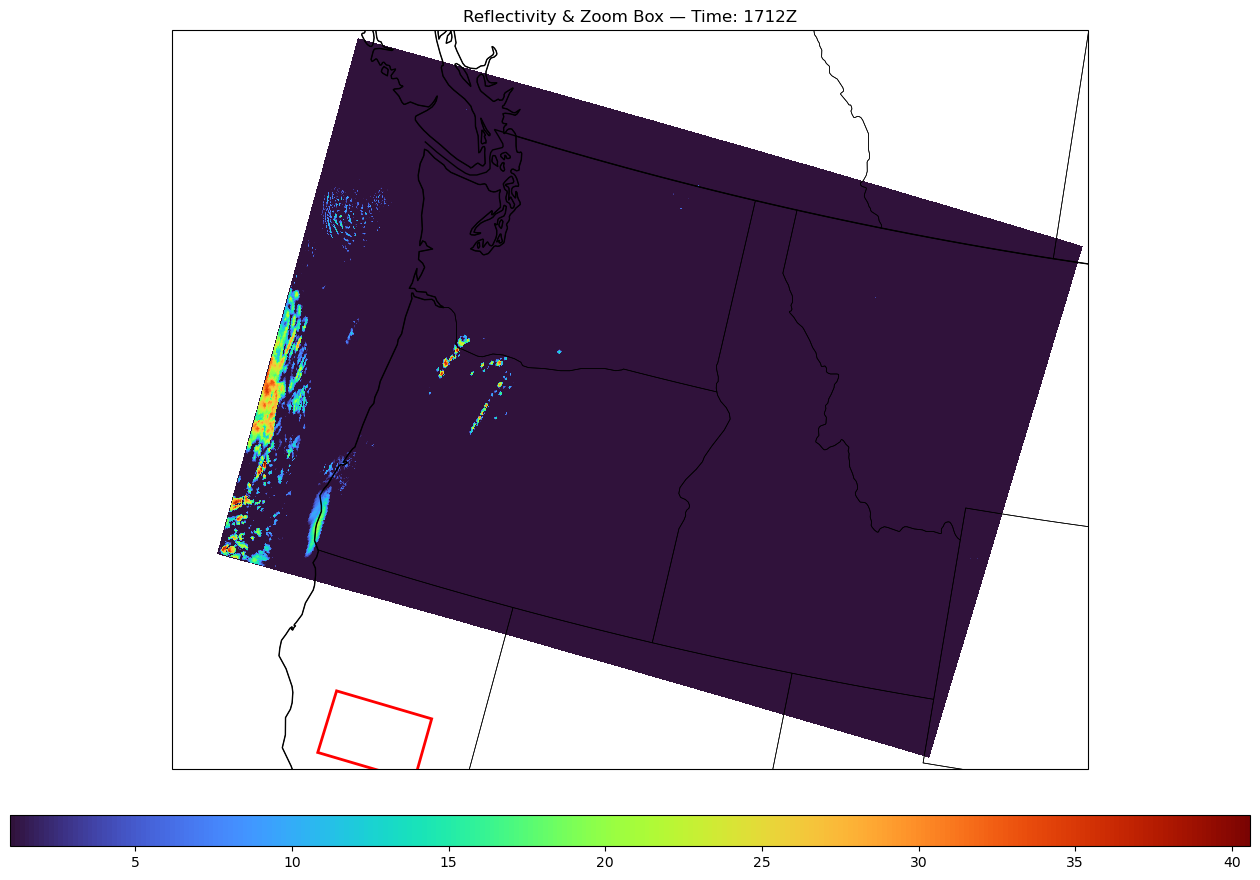

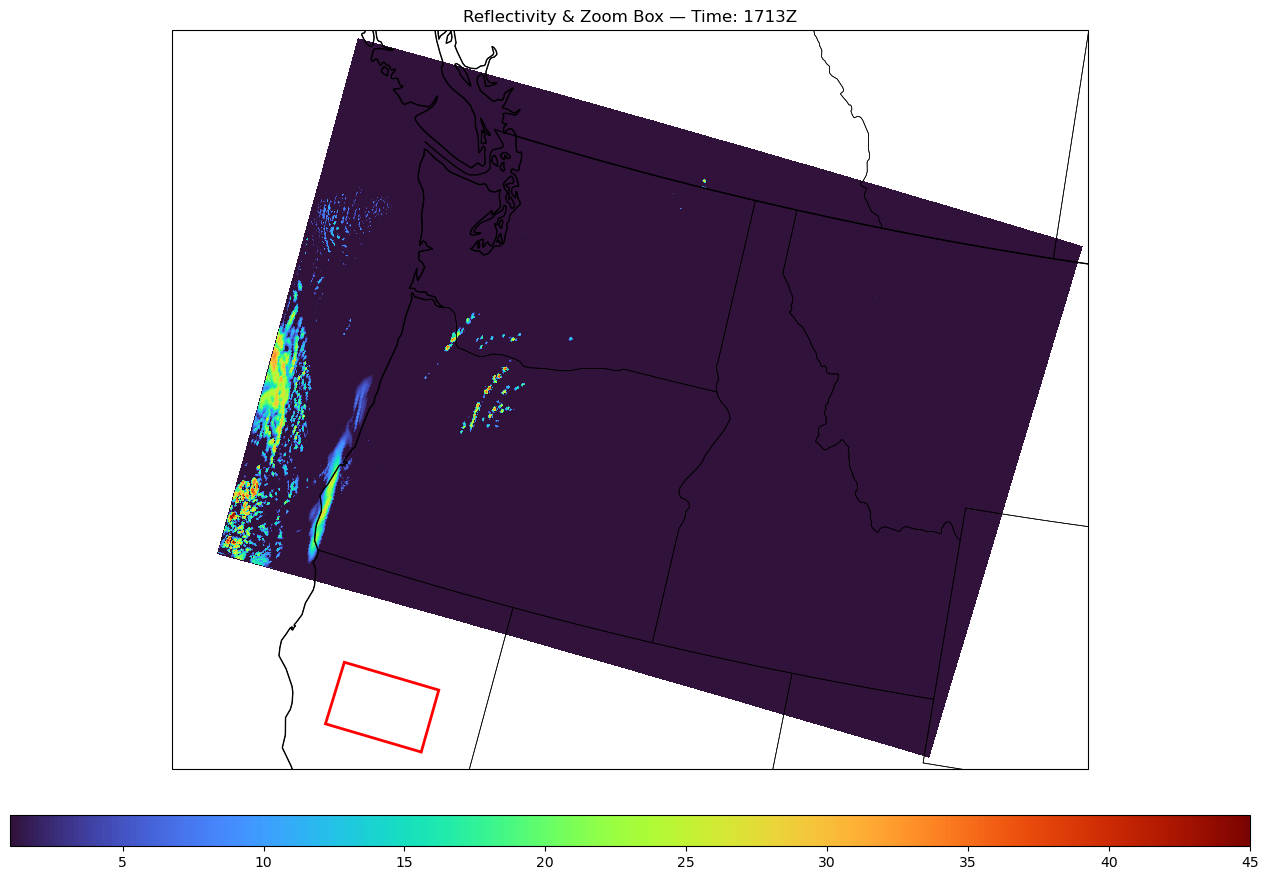

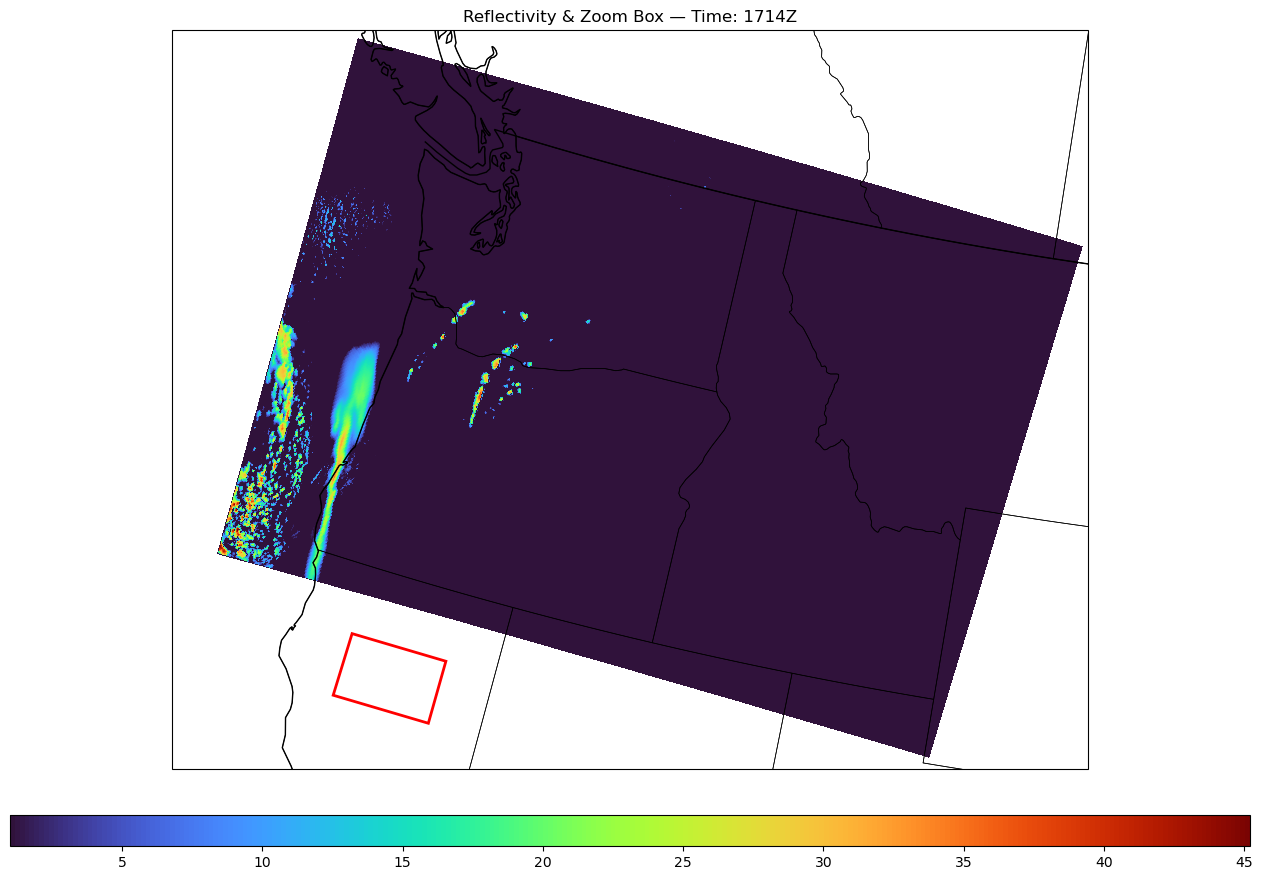

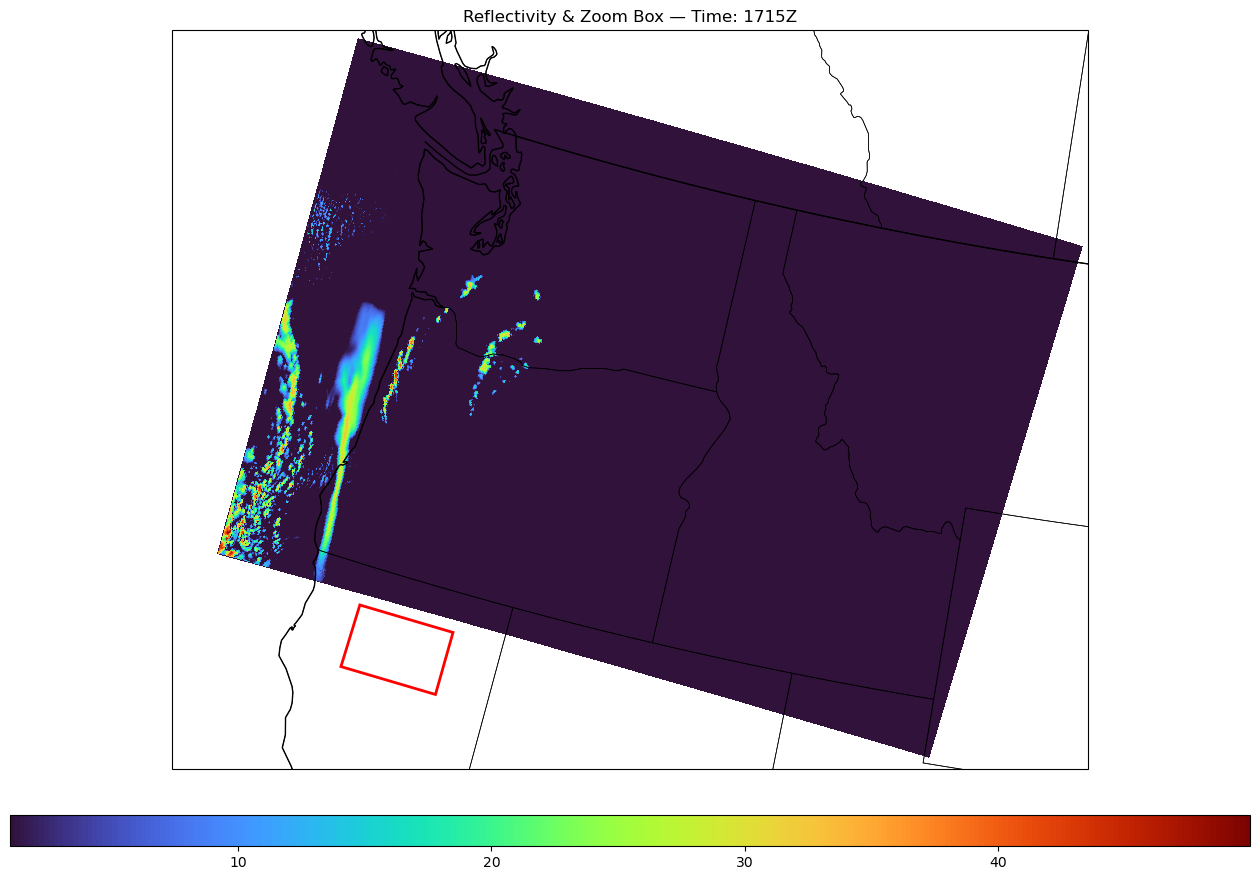

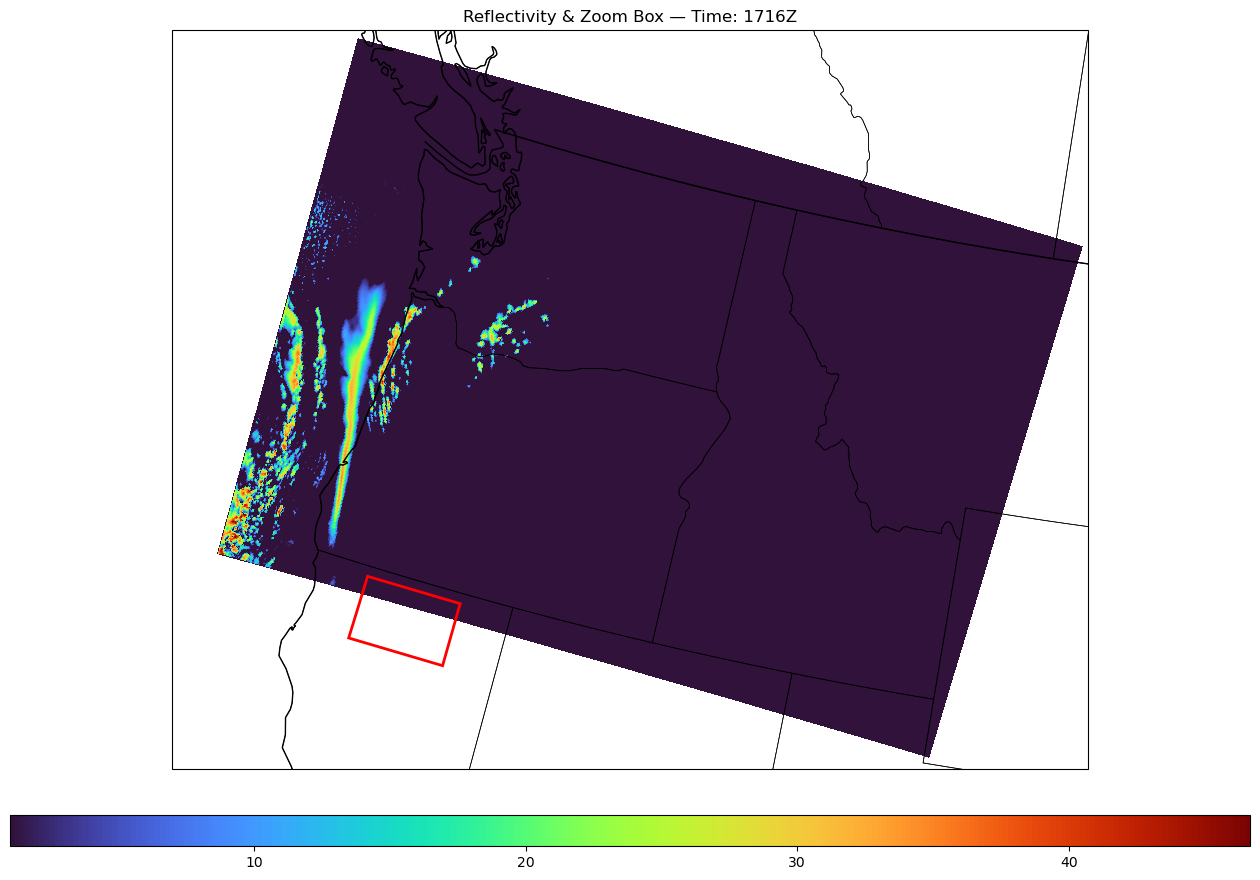

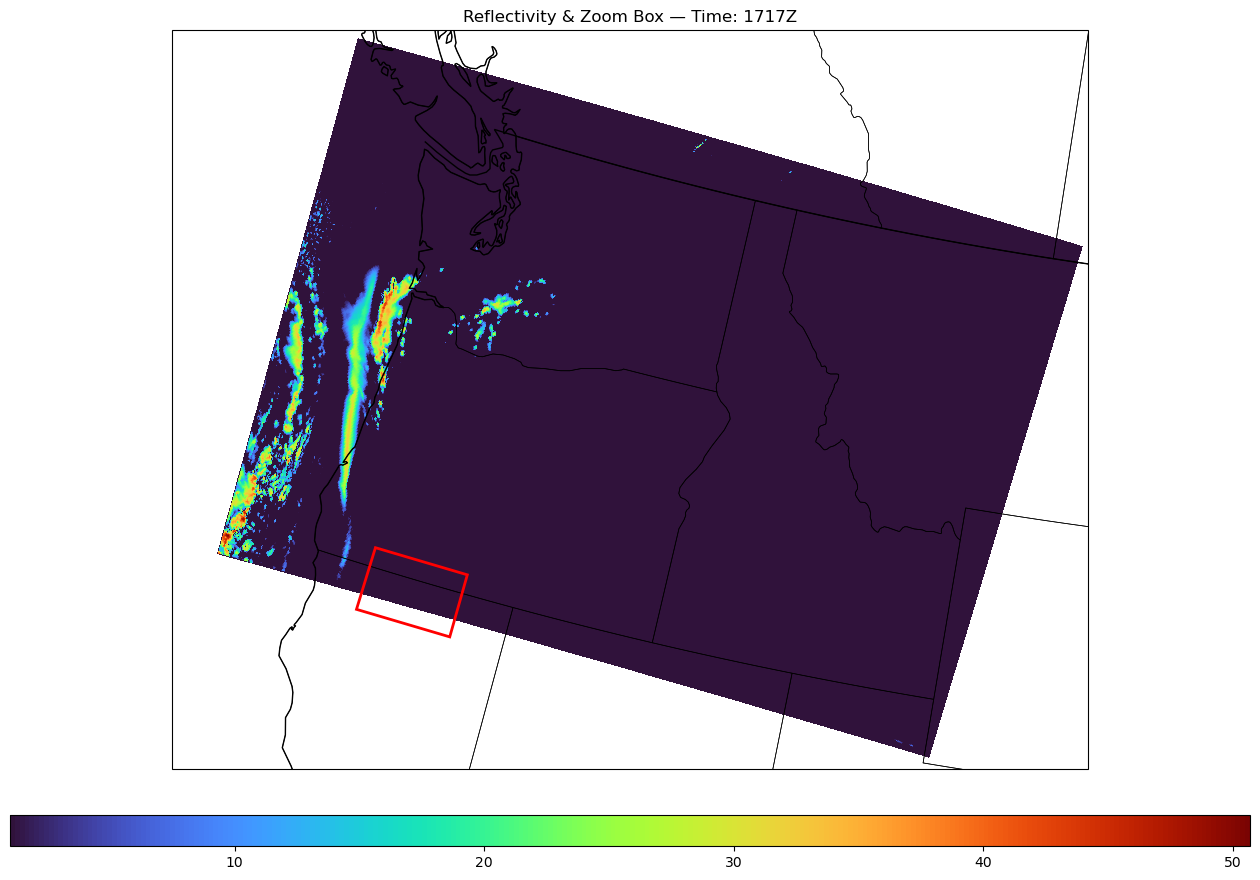

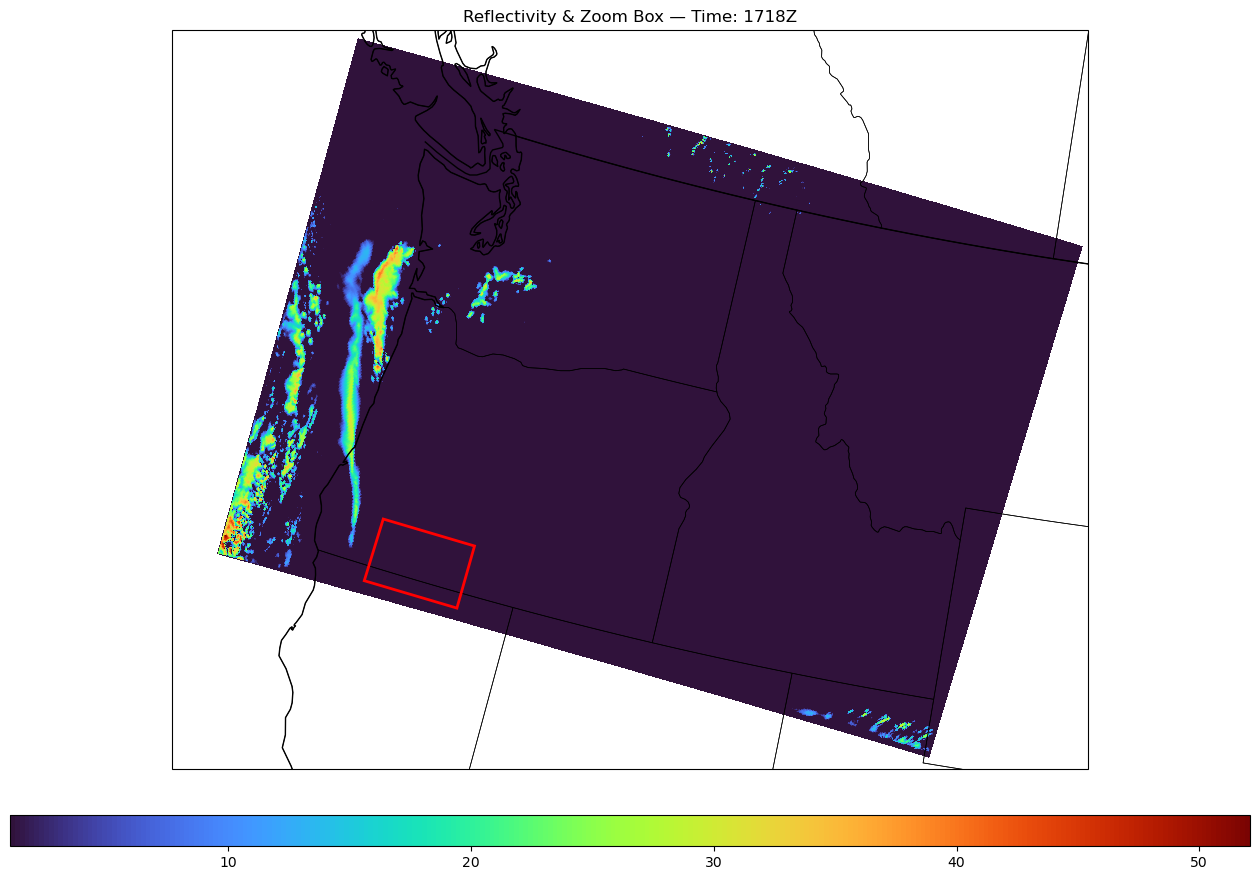

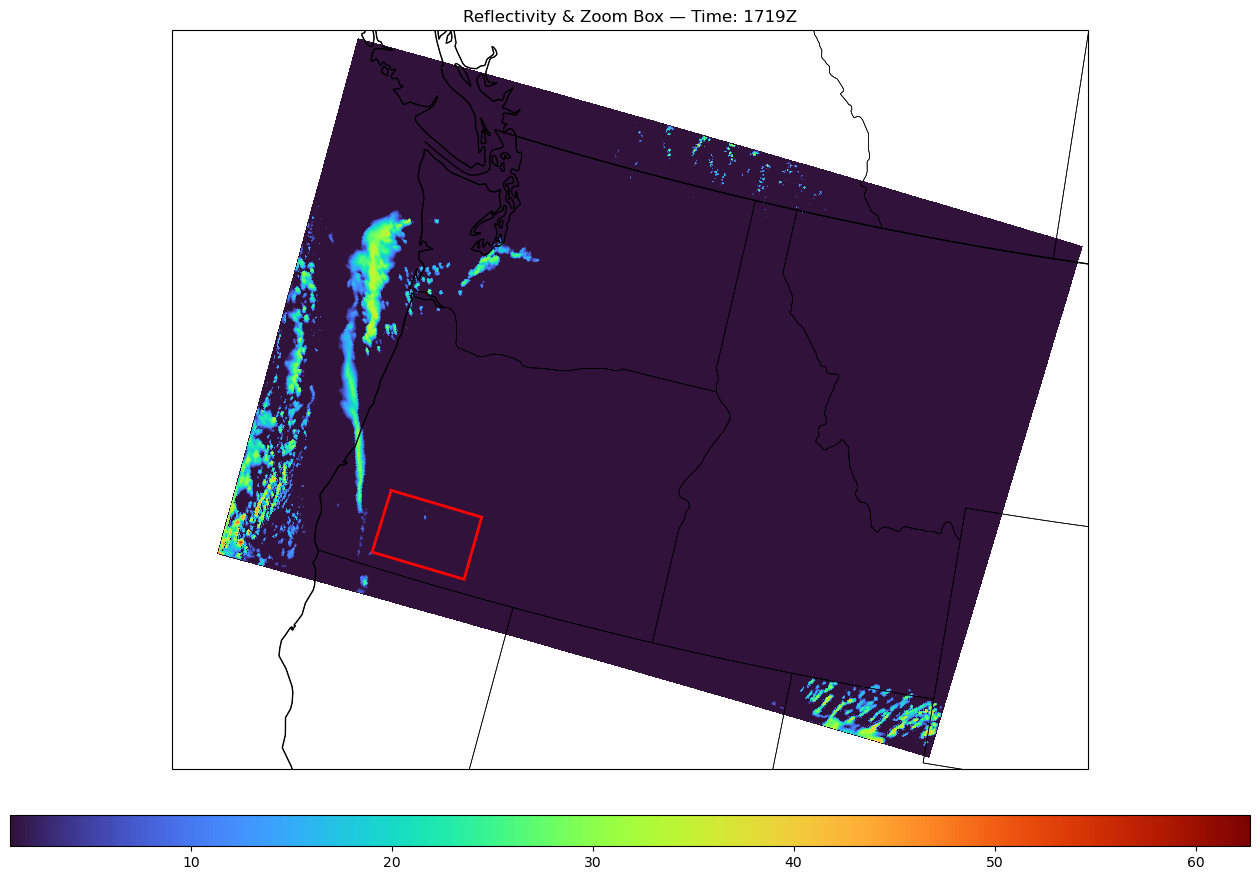

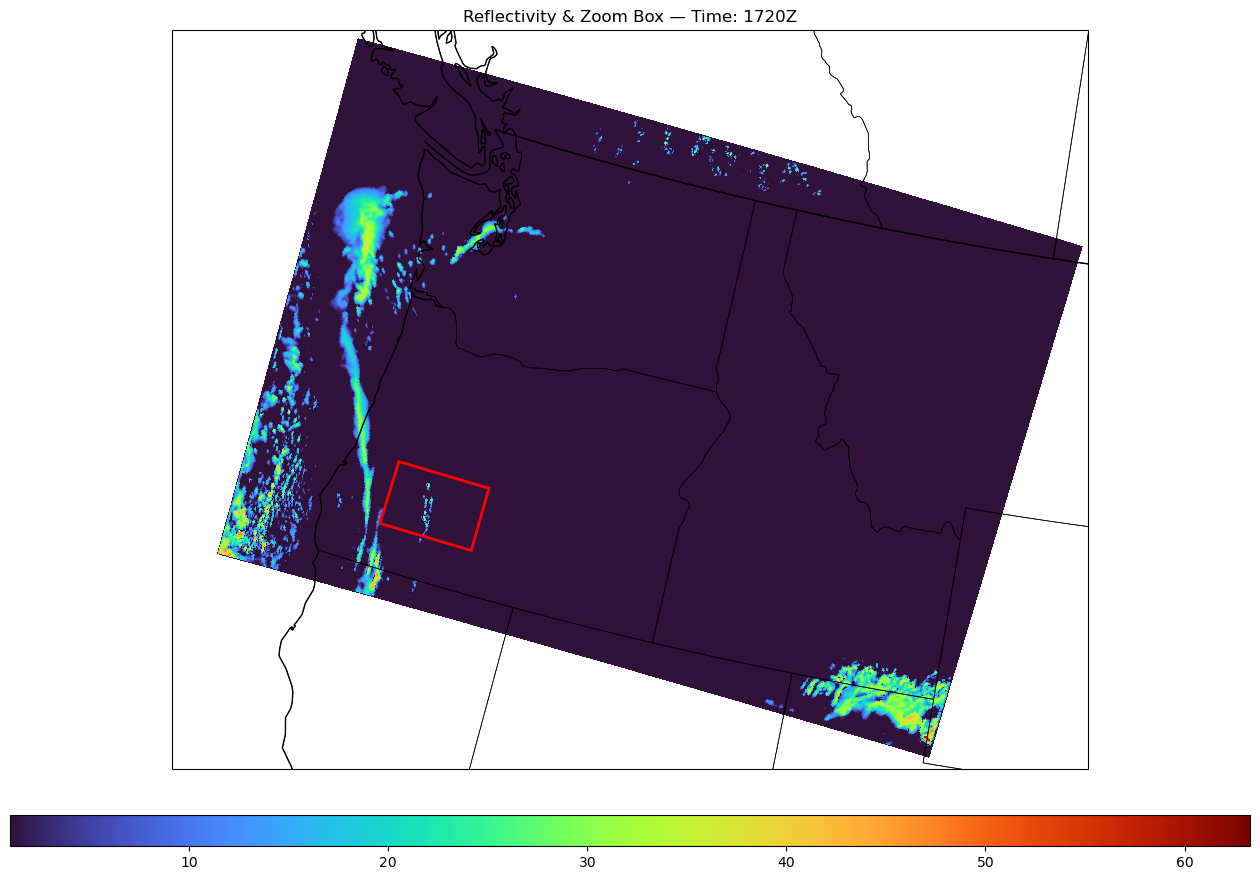

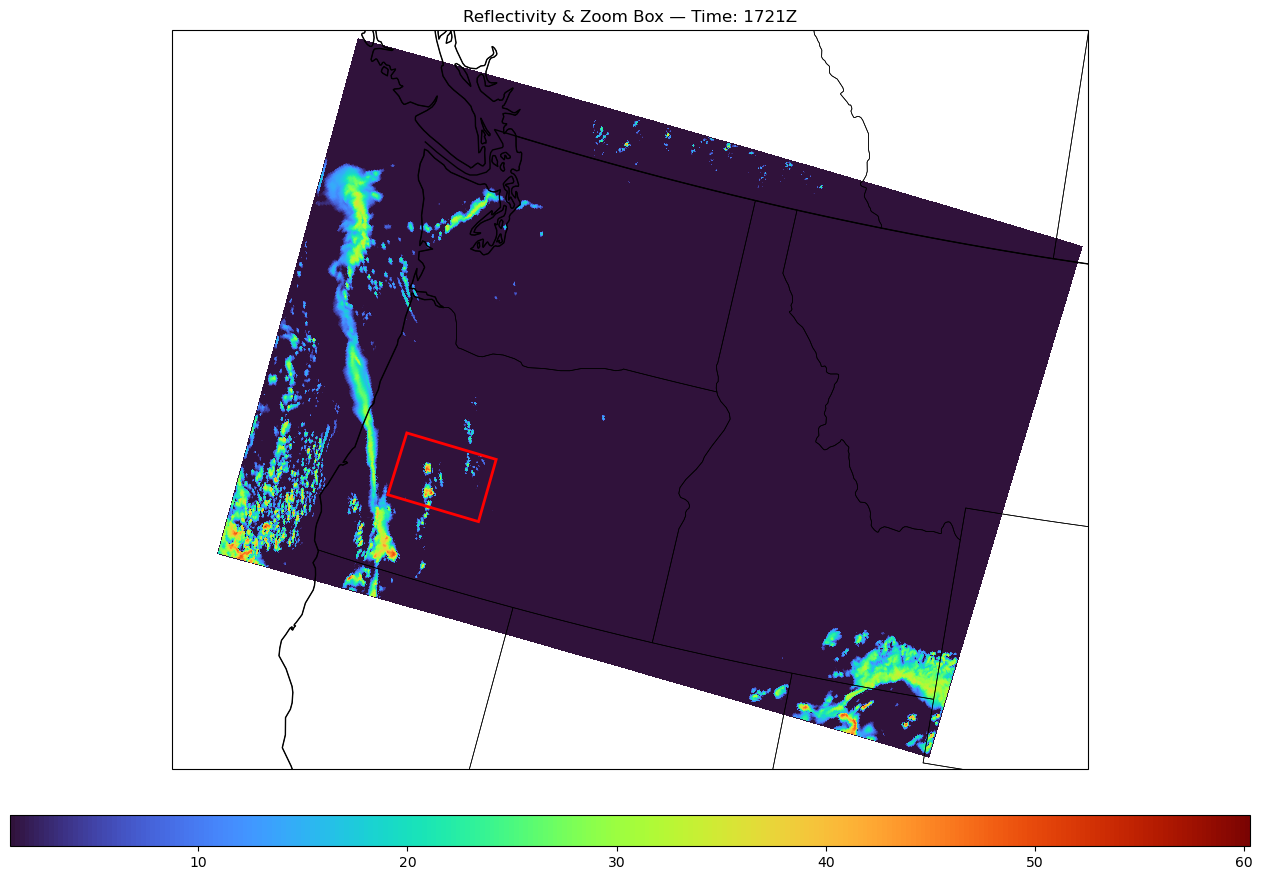

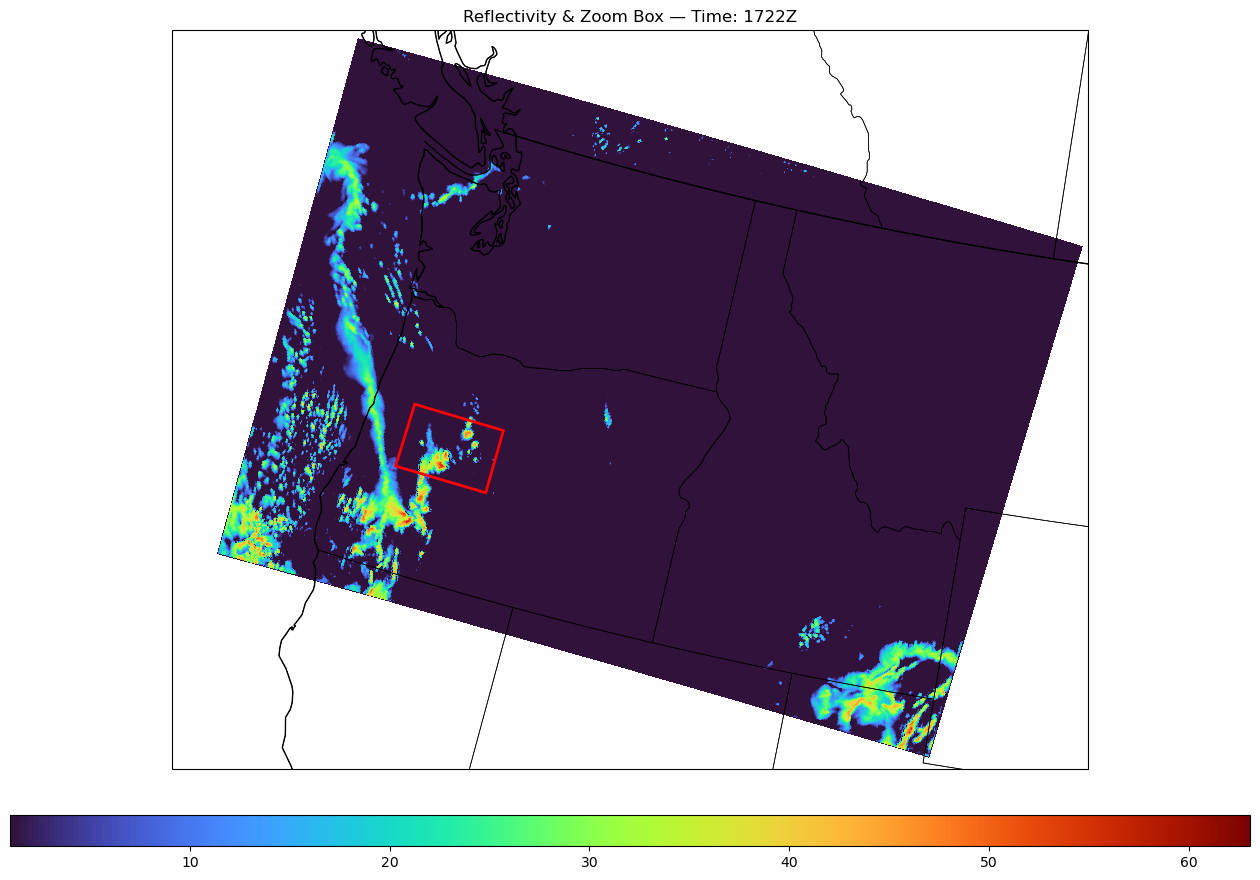

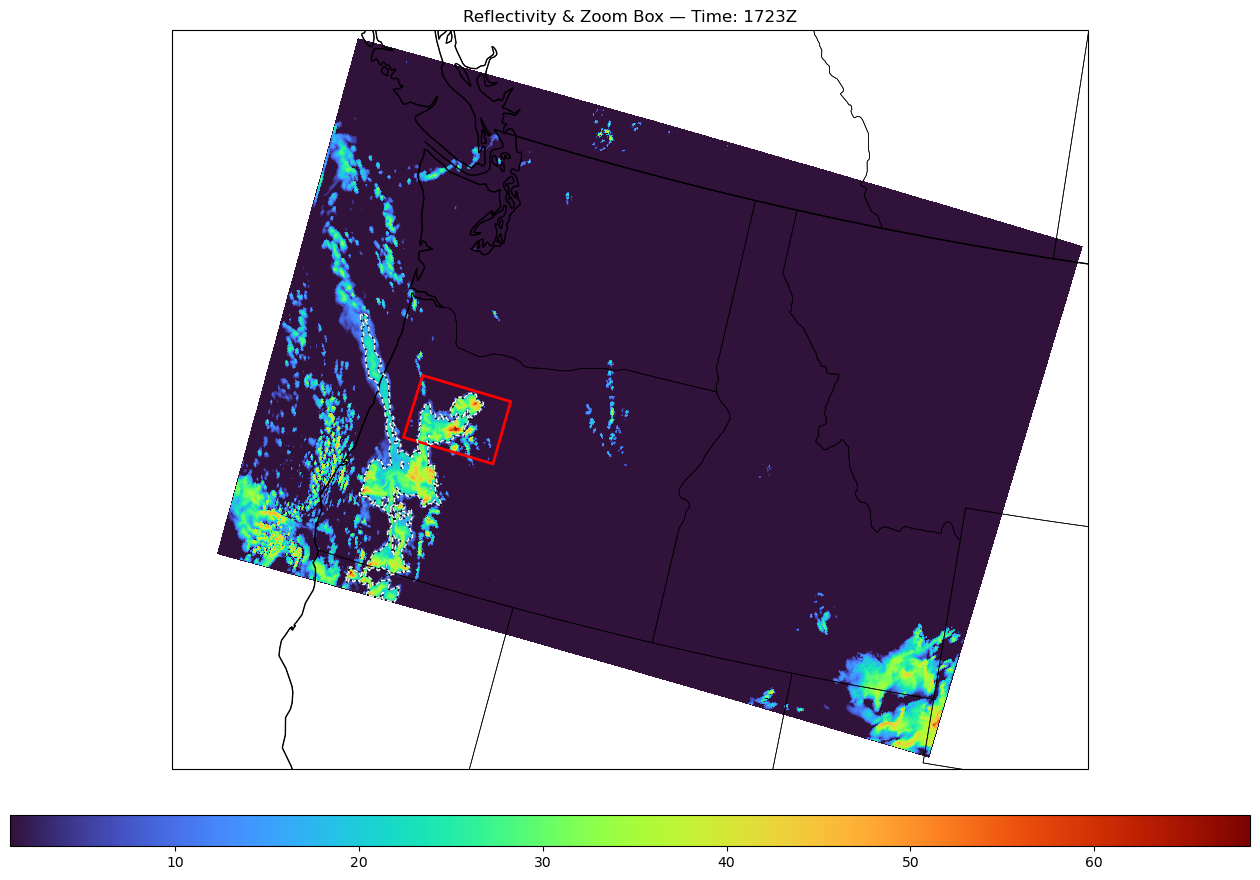

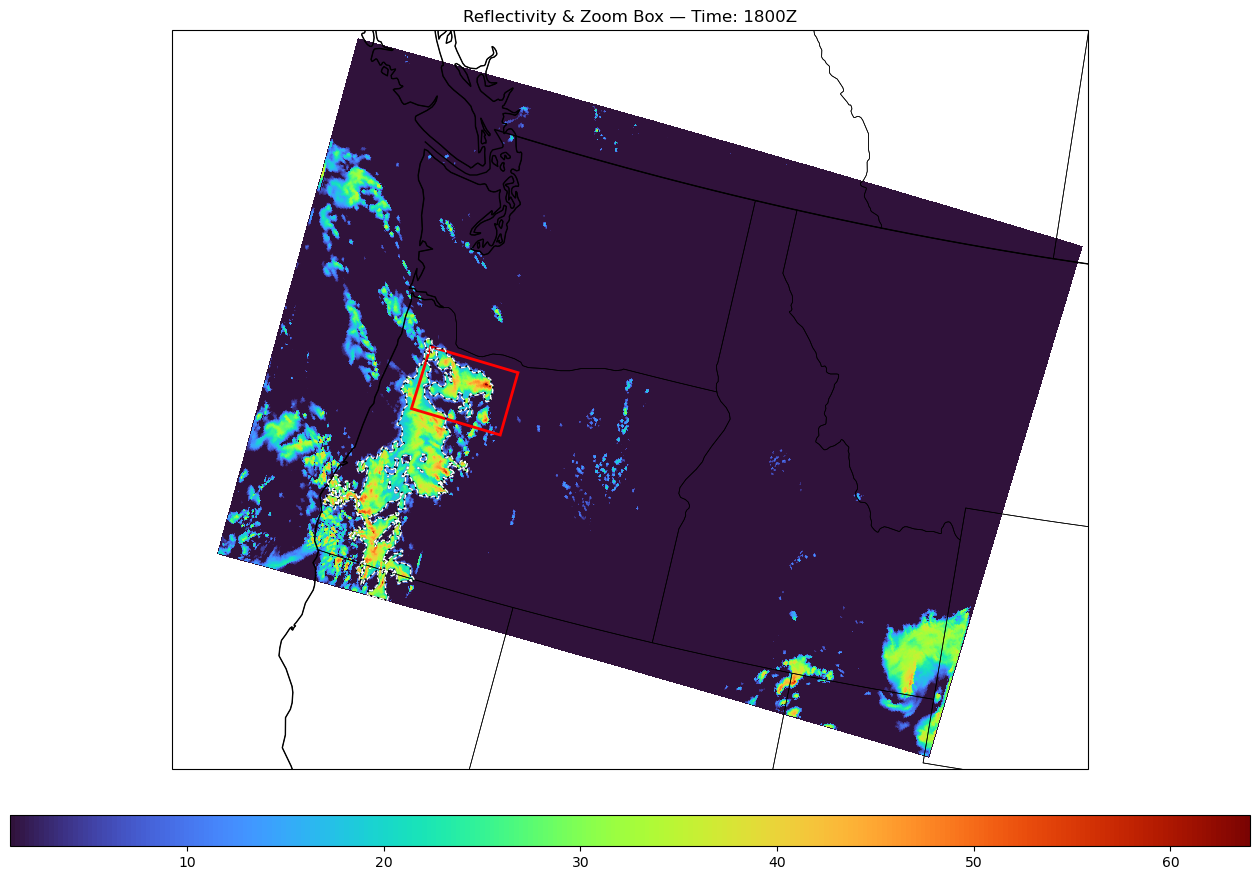

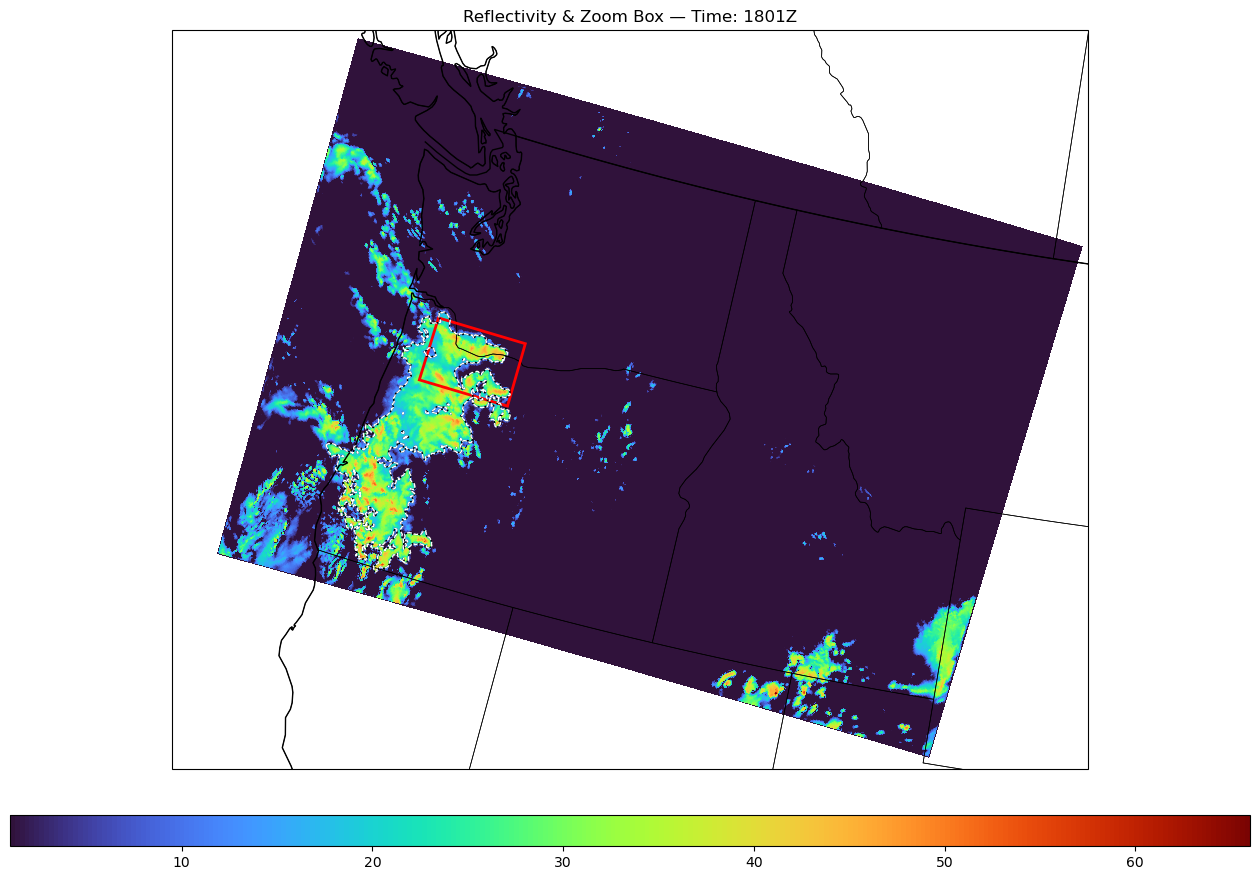

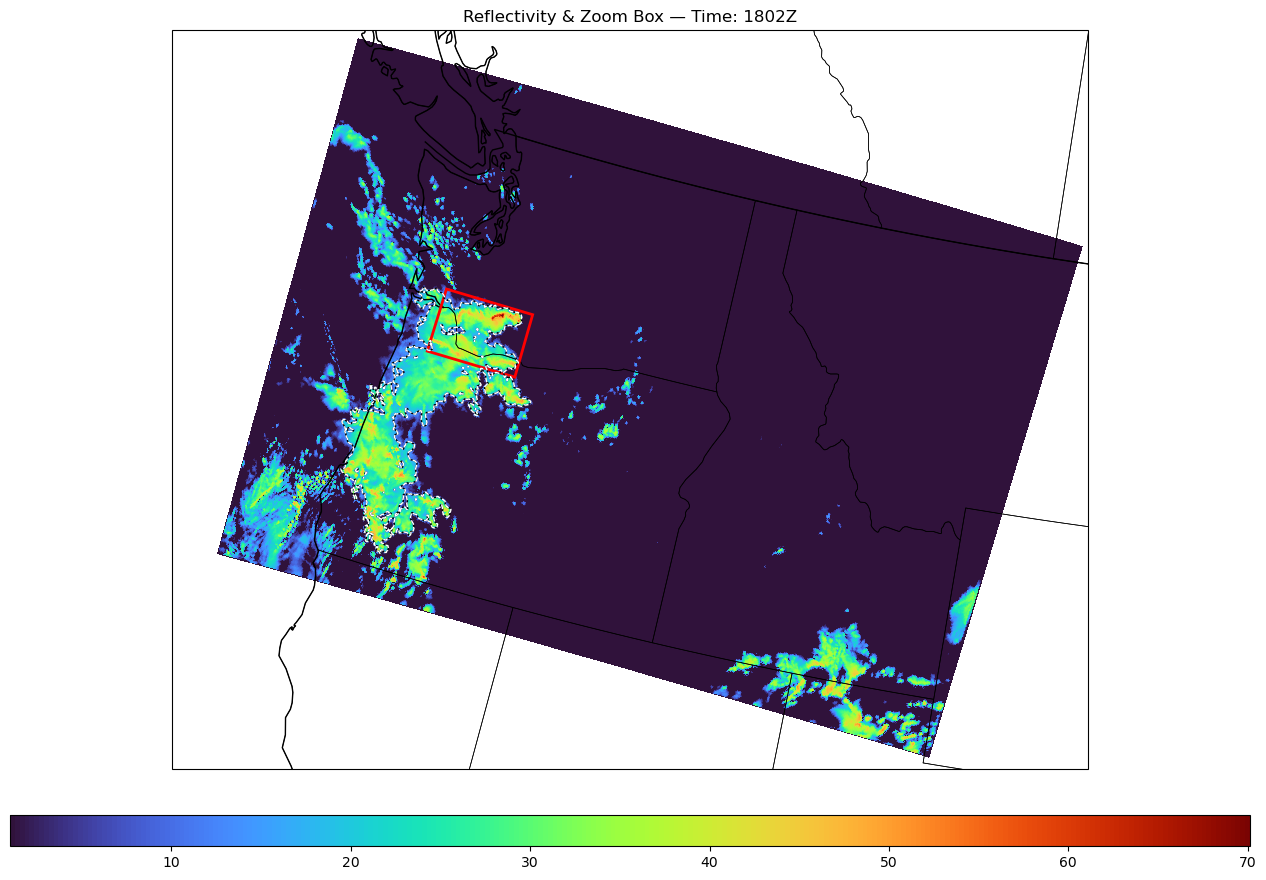

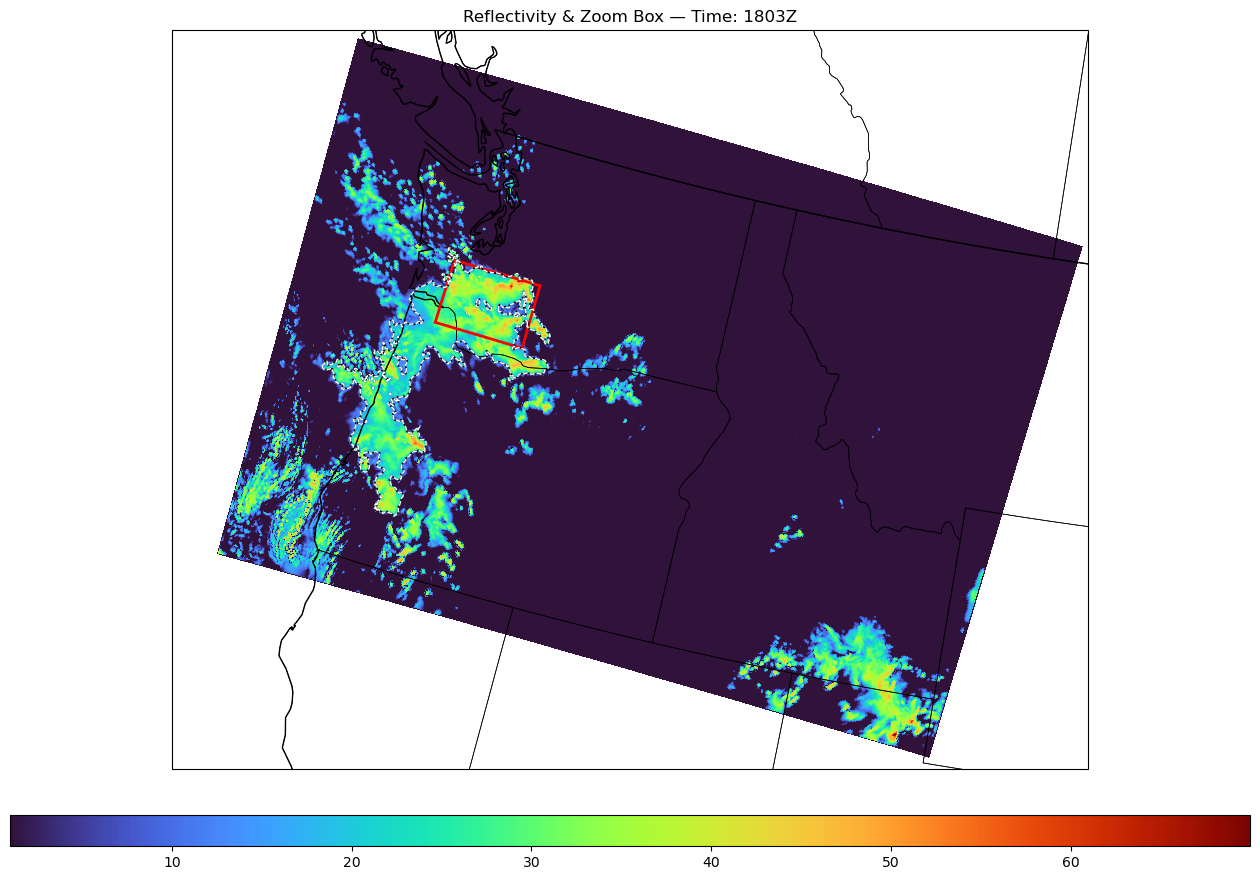

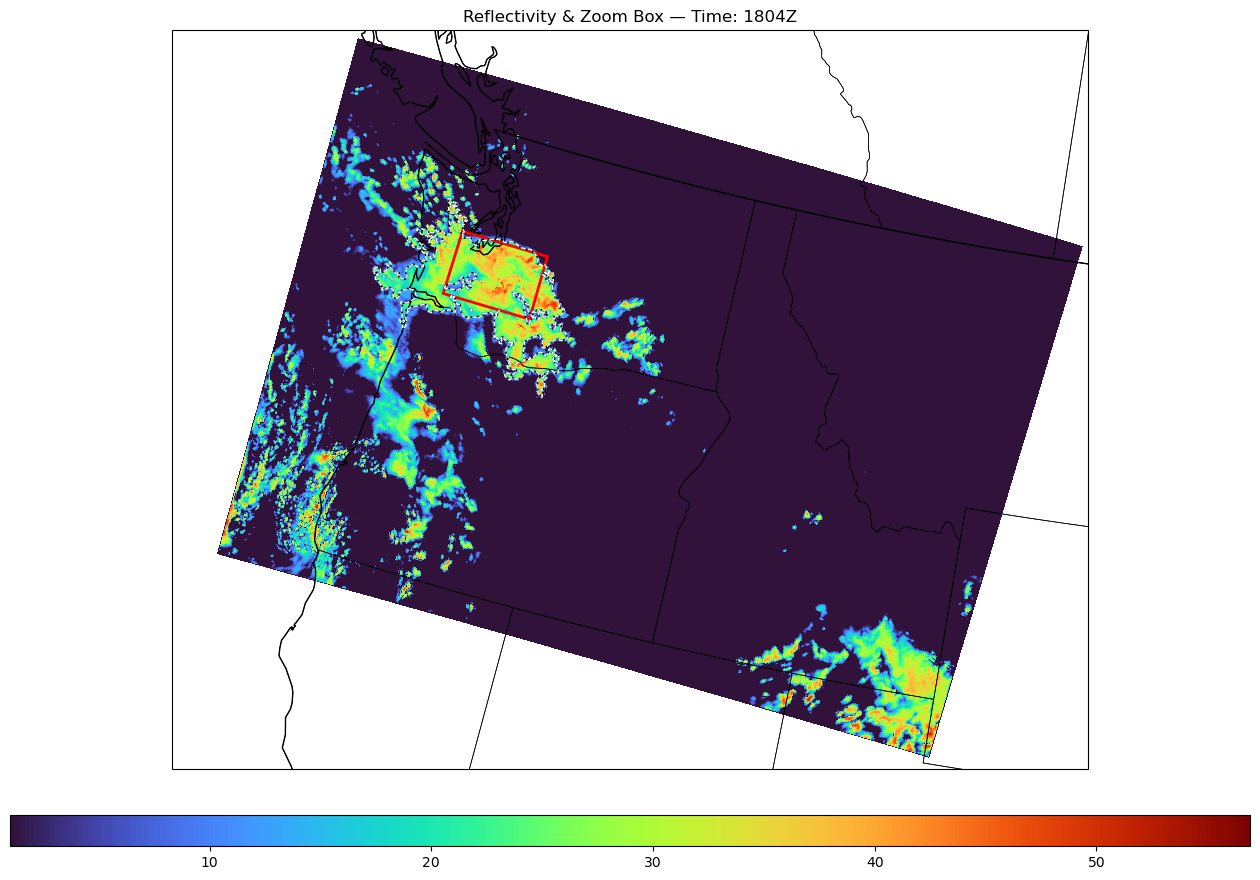

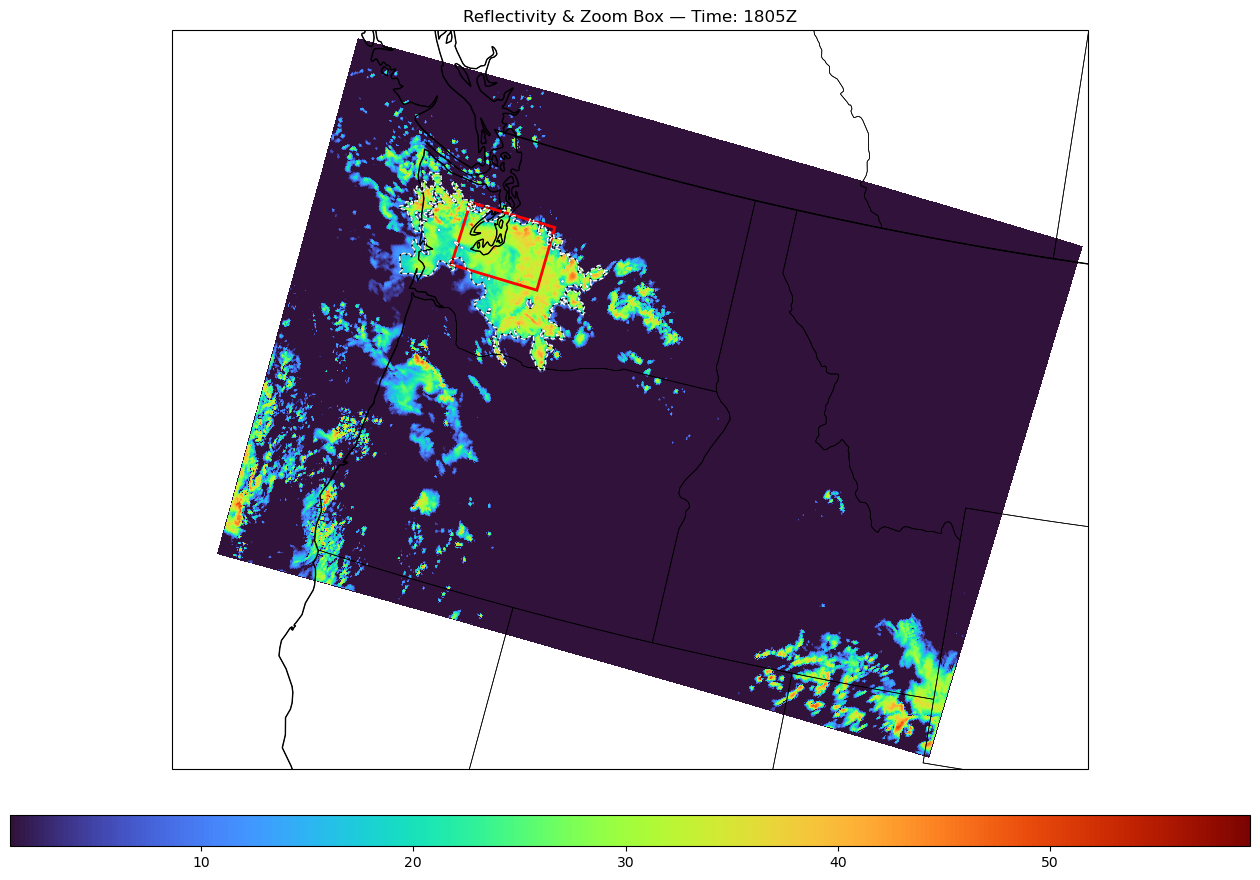

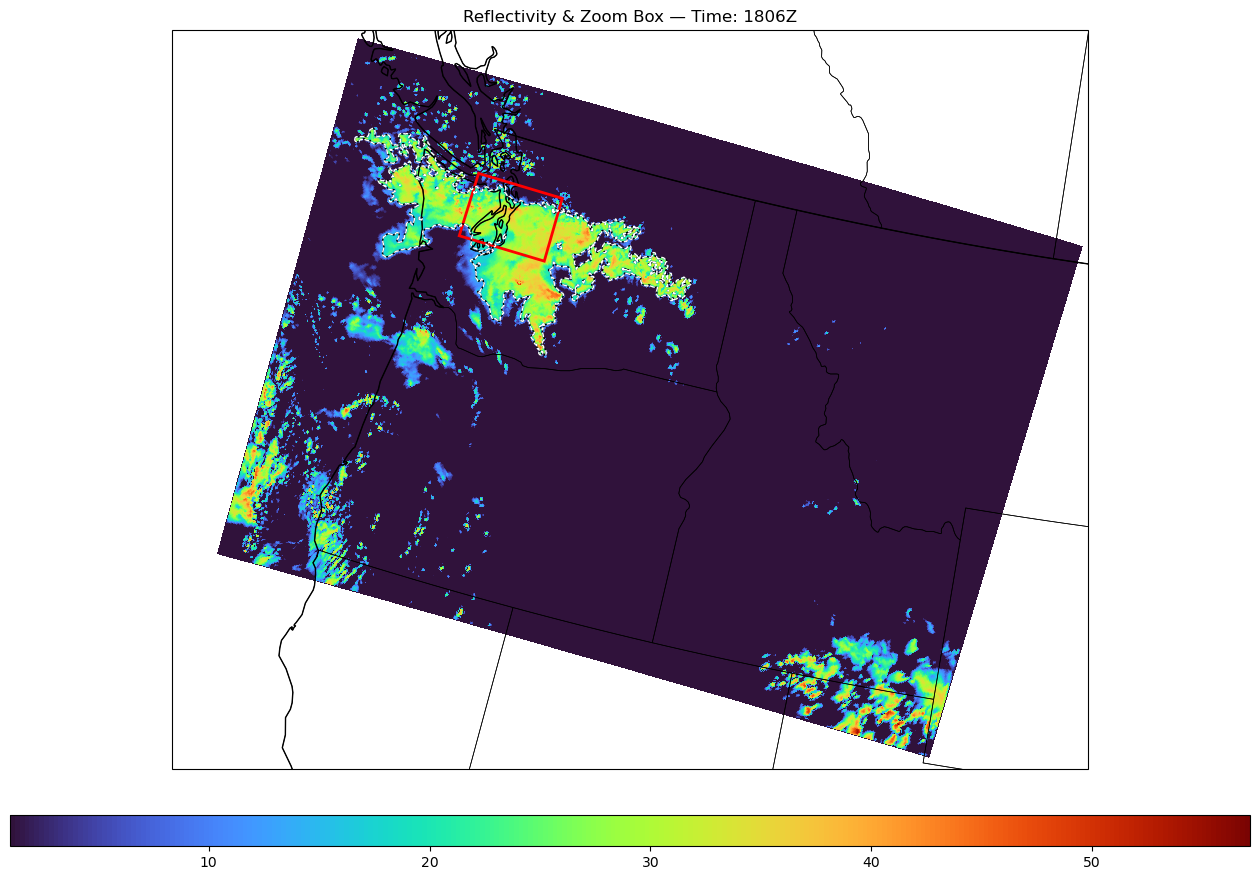

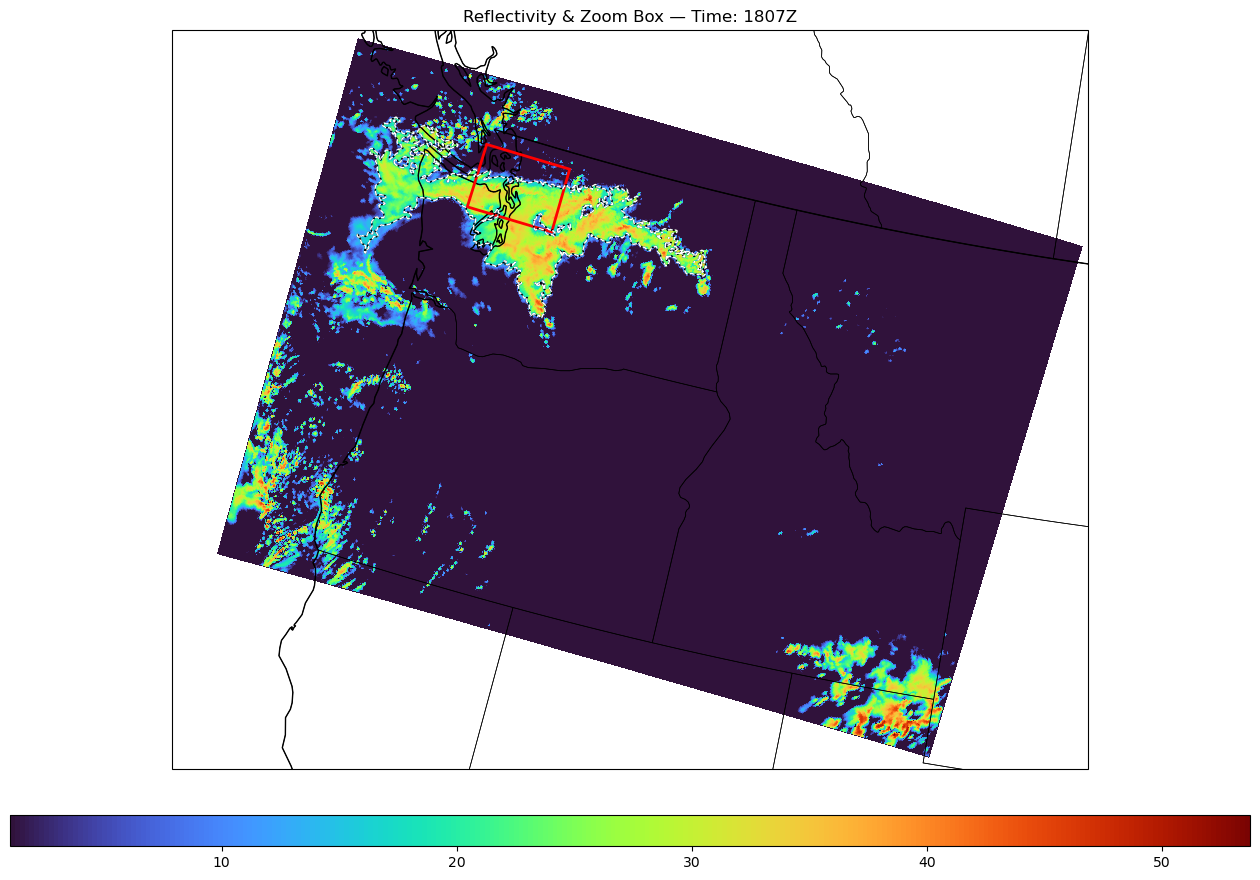

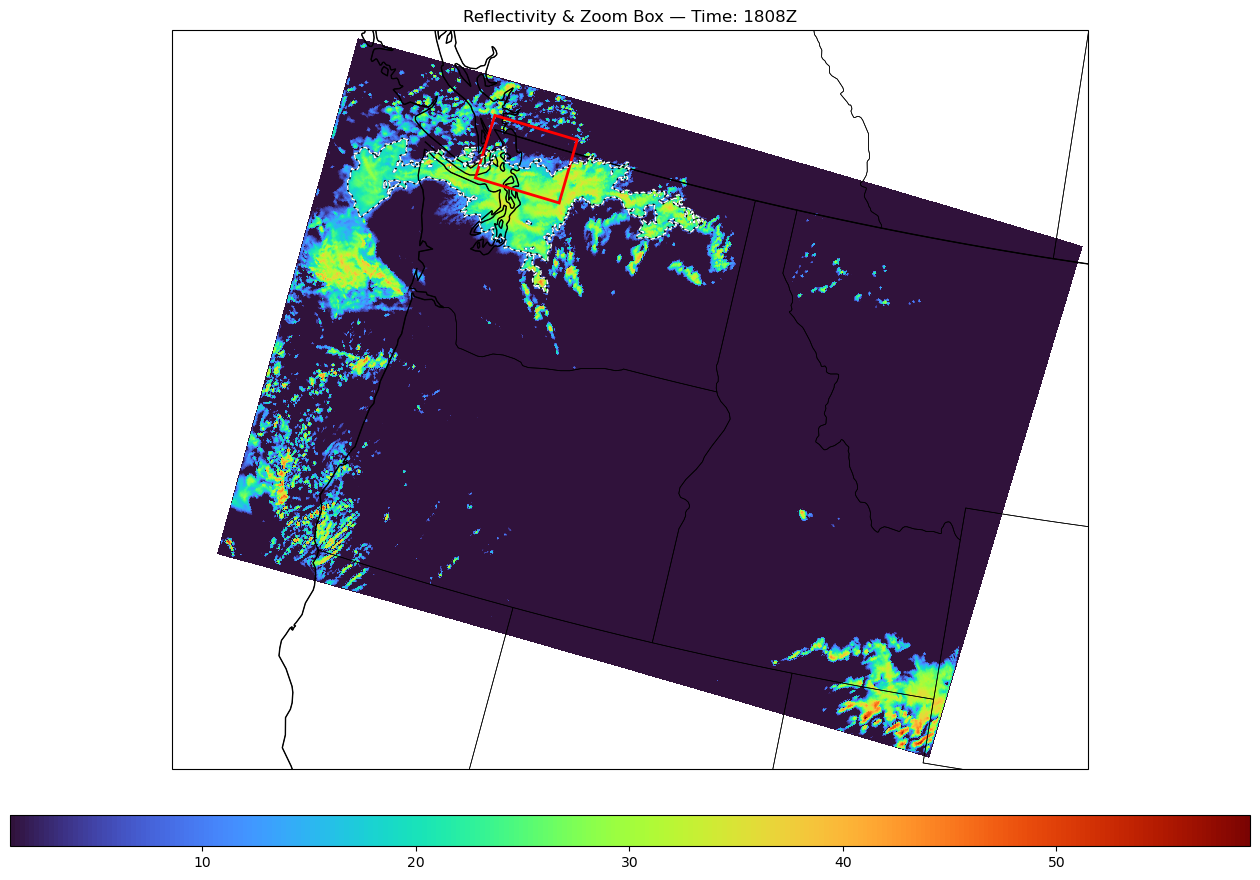

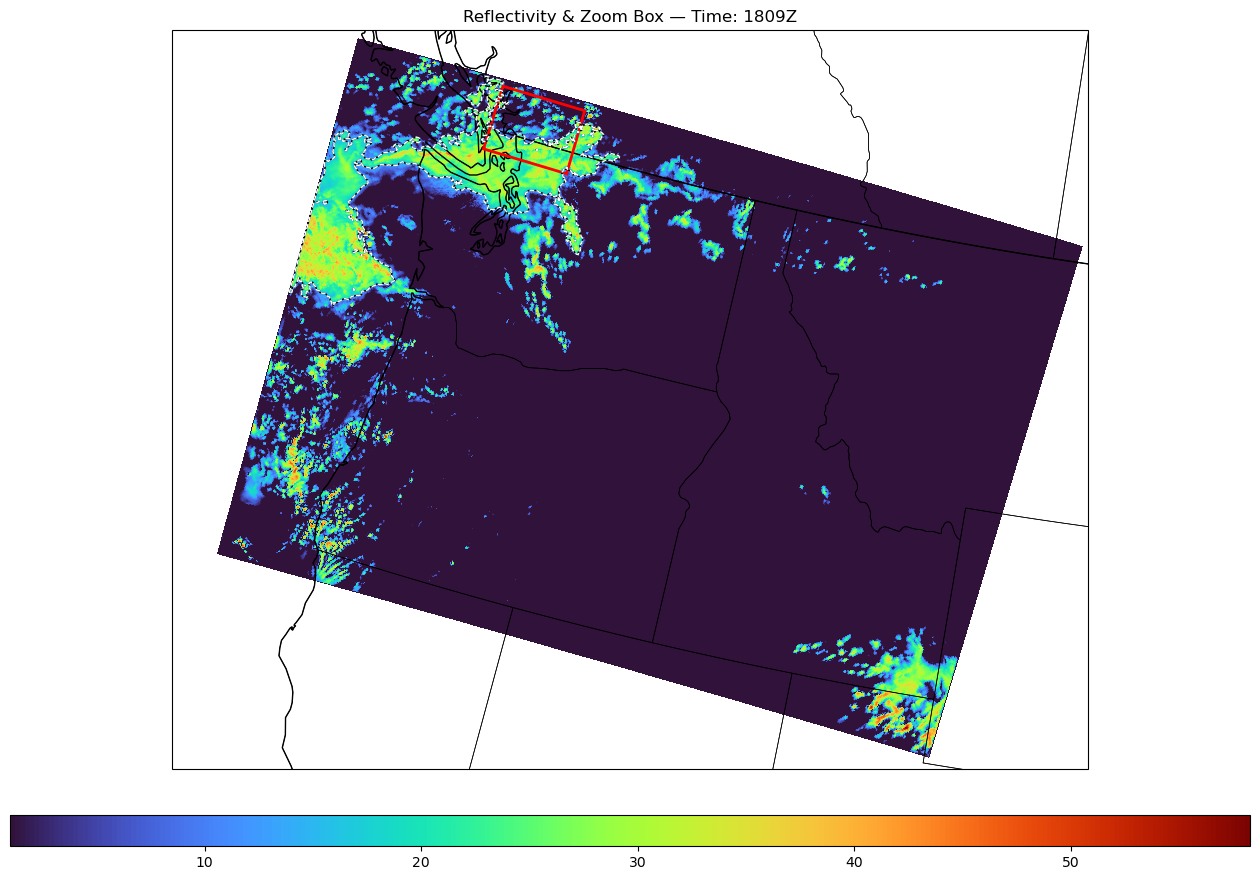

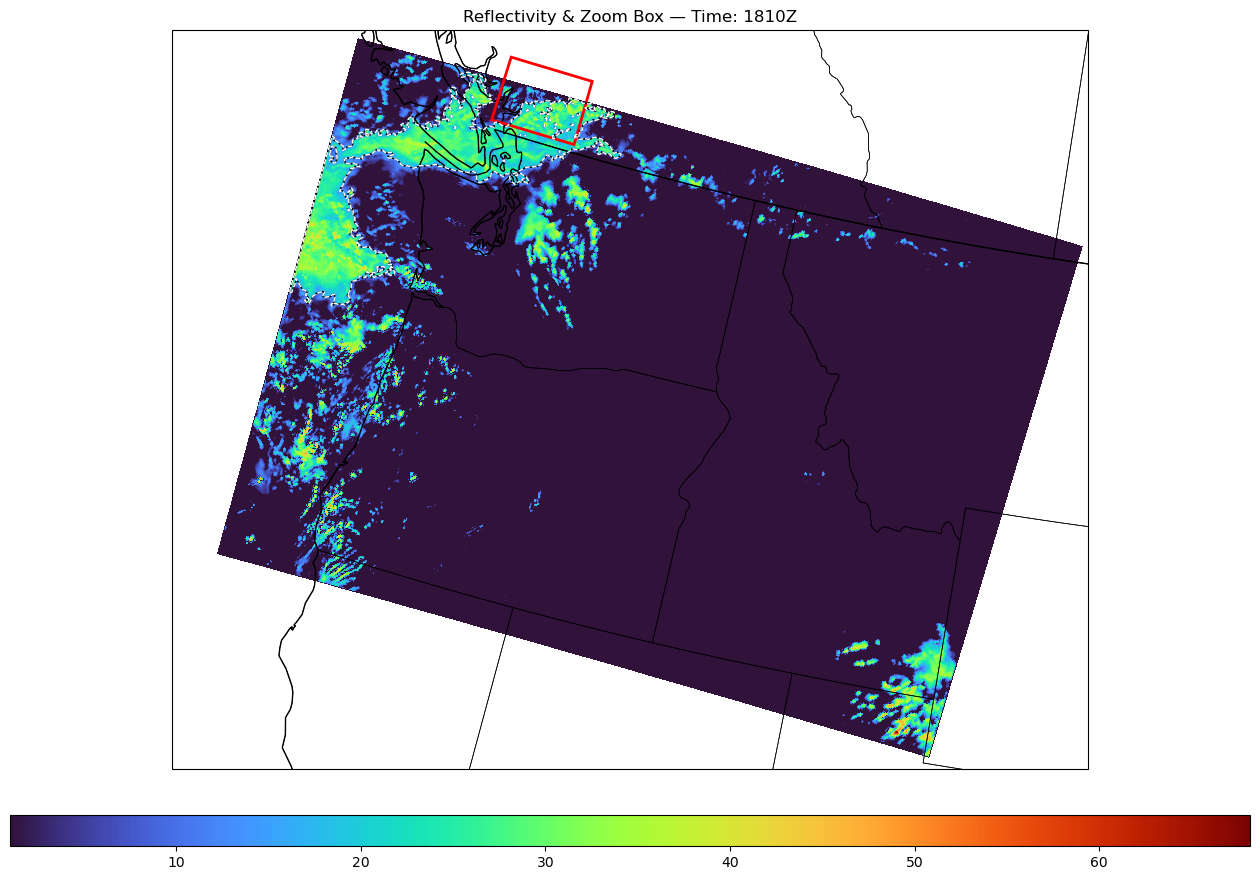

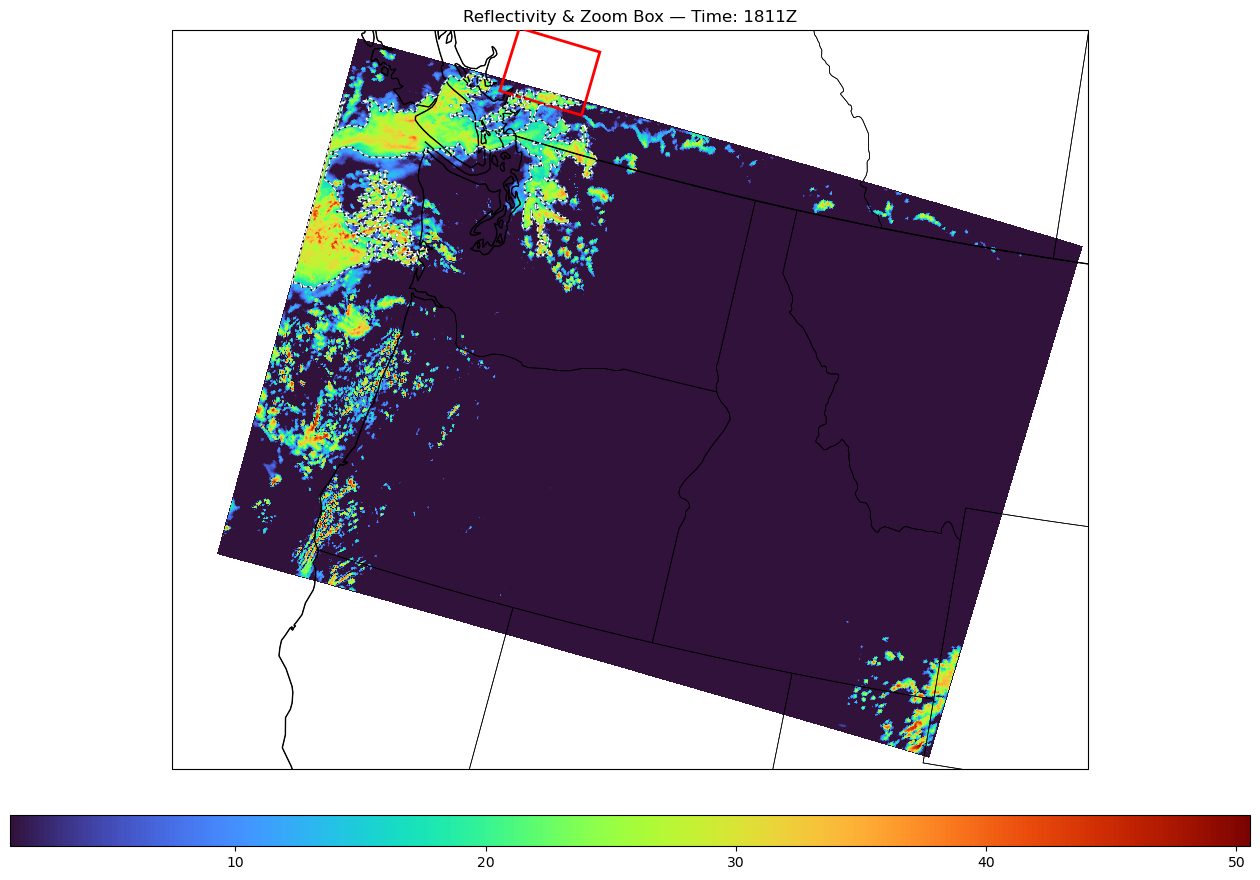

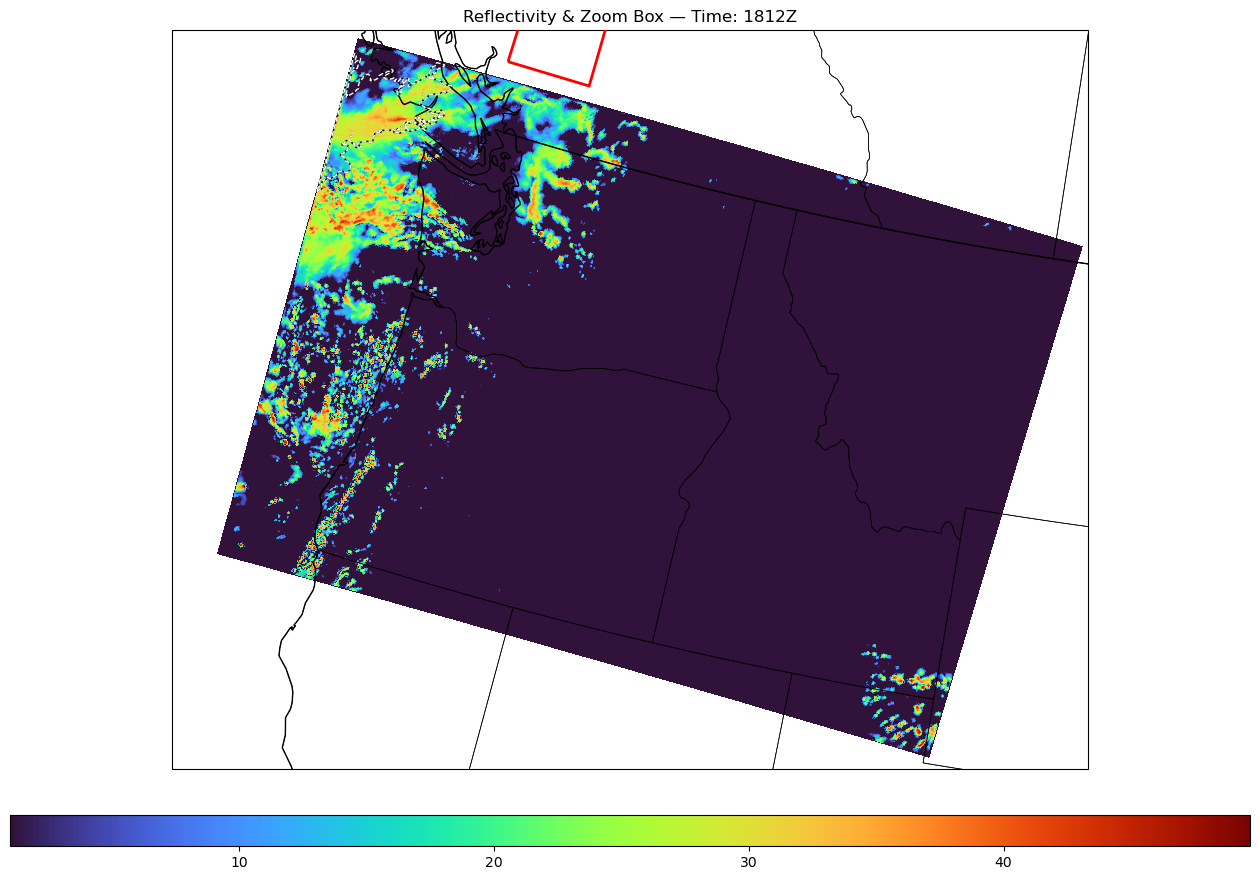

In [48]:
# for figuring out zoom
import matplotlib.patches as patches
zoom = [-123, 39, 2, 1, -0.02, 0.46, -0.02, 0.46]
projection = ccrs.LambertConformal()

coast = cfeature.COASTLINE.with_scale('50m')
states = cfeature.STATES.with_scale('50m')
borders = cfeature.BORDERS.with_scale('50m')

for i in range(len(ds['XTIME'])):
    time = ds['XTIME'].isel(Time=i)
    frame = ds['REFL_10CM_sfc'].isel(Time=i).load()

    lat_coord = [name for name in frame.coords if "LAT" in name][0]
    long_coord = [name for name in frame.coords if "LONG" in name][0]

    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(1, 1, 1, projection=projection)

    # Full domain extent
    lon_min = frame[long_coord].min().item()
    lon_max = frame[long_coord].max().item()
    lat_min = frame[lat_coord].min().item()
    lat_max = frame[lat_coord].max().item()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    ax.add_feature(coast, linewidth=1)
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(borders, linewidth=1, edgecolor='black')

    p = ax.pcolormesh(
        frame[long_coord], frame[lat_coord], frame,
        cmap='turbo', transform=ccrs.PlateCarree(), vmin=1
    )

    # Compute zoom corners using parameterized logic
    x0_i = zoom[0] + i * zoom[4]
    y0_i = zoom[1] + i * zoom[5]
    x1_i = zoom[0] + zoom[2] + i * zoom[6]
    y1_i = zoom[1] + zoom[3] + i * zoom[7]

    # Plot zoom box as a red rectangle
    zoom_rect = patches.Rectangle(
        (x0_i, y0_i), x1_i - x0_i, y1_i - y0_i,
        linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree(), zorder=10
    )
    ax.add_patch(zoom_rect)

    # Overlay feature outline
    feature_time = masks.sel(time=pd.to_datetime(str(time.values)), method='nearest')
    mask = (feature_time['tracknumber'] == 6)
    if mask.any():
        mask_np = mask.squeeze().values
        mask_data = np.where(mask_np, 1.0, 0.0)
        ax.contour(
            feature_time['lon'], feature_time['lat'], mask_data,
            levels=[0.5], colors='black', linewidths=1, transform=ccrs.PlateCarree(), zorder=11
        )
        ax.contour(
            feature_time['lon'], feature_time['lat'], mask_data,
            levels=[0.5], colors='white', linewidths=1, linestyles='dashed', transform=ccrs.PlateCarree(), zorder=12
        )

    ax.set_title(f'Reflectivity & Zoom Box — Time: {pd.to_datetime(str(time.values)).strftime("%d%HZ")}')
    plt.colorbar(p, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    plt.show()
    plt.close('all')
    gc.collect()
